# OLS and GWR for vaccination uptake rates

## Import packages

In [202]:
import pandas as pd
import libpysal
import matplotlib.pyplot as plt
import mgwr
from mgwr.gwr import GWR, MGWR
import numpy as np
import pysal
from pysal import model
import geopandas as gpd
import esda

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

from matplotlib import colors

import copy

from importlib import reload
import run_OLS
reload(run_OLS)

import multiprocessing as mp

import utilities_plot
reload(utilities_plot)

import pickle

## Set up parallel computing for GWR

In [2]:
#This might be needed to turn off the OpenMP multi-threading
%env OMP_NUM_THREADS = 1

env: OMP_NUM_THREADS=1


In [3]:
#Parrallelization is more favored when you your data are large and/or your machine have many many cores.
#mgwr has soft dependency of numba, please install numba if you need better performance (pip install numba).

n_proc = 8 #two processors
pool = mp.Pool(n_proc) 

## Import shapefile

Download and read MSOA shapefile data.

If the MSOA shapefile is not there, run the next cell to download it.

In [4]:
# note that this dataset contains all 7201 MSOAs in England. This dataset is used as it contains the high resolution boundary and neighbour topology of MSOAs 
# url = 'https://github.com/jreades/fsds/raw/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip'

#! wget $url

In [5]:
# path_data_folder = '../Data'
gdf = gpd.read_file(f"../Data/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip!Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7201 entries, 0 to 7200
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    7201 non-null   int64   
 1   MSOA11CD    7201 non-null   object  
 2   MSOA11NM    7201 non-null   object  
 3   MSOA11NMW   7201 non-null   object  
 4   BNG_E       7201 non-null   int64   
 5   BNG_N       7201 non-null   int64   
 6   LONG        7201 non-null   float64 
 7   LAT         7201 non-null   float64 
 8   Shape__Are  7201 non-null   float64 
 9   Shape__Len  7201 non-null   float64 
 10  geometry    7201 non-null   geometry
dtypes: float64(4), geometry(1), int64(3), object(3)
memory usage: 619.0+ KB


In [6]:
gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

## Import uptake data

In [7]:
# import df_uptake data
df_uptake = pd.read_csv("../Data/vaccine_uptake_socioeco.csv")
df_uptake = df_uptake.rename({'E2sfca_30_min_supply_value':'accessibility_vaccine'}, axis = 1)

In [8]:
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE',
       'msoa_imd_decile', 'pct_White', 'pct_Mixed', 'pct_Asian', 'pct_black',
       'pct_other', 'pct_hh_car', 'msoa_quintile', 'MSOA11CD', 'income_score',
       'employ_score', 'edu_score', 'health_score', 'crime_score',
       'housing_score', 'livEnv_score', 'accessibility_vaccine'],
      dtype='object')

In [9]:
df_msoa_excl_london = pd.read_csv('../accessibility_imd_ethnic_exclude.csv')

In [10]:
df_vaccine_excl_london = df_uptake[df_uptake.MSOA11CD.isin(df_msoa_excl_london.MSOA11CD)]

In [11]:
df_vaccine_only_london = df_uptake[~df_uptake.MSOA11CD.isin(df_msoa_excl_london.MSOA11CD)]

In [12]:
df_uptake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6787 entries, 0 to 6786
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      6787 non-null   int64  
 1   MSOA                            6787 non-null   object 
 2   18over1st_dose                  6787 non-null   int64  
 3   18over2nd_dose                  6787 non-null   int64  
 4   pop0_17                         6787 non-null   int64  
 5   pop18over                       6787 non-null   int64  
 6   vaccination_percentage_1stdose  6787 non-null   float64
 7   vaccination_percentage_2nddose  6787 non-null   float64
 8   vaccination_percentage_total    6787 non-null   float64
 9   MSOA Code                       6787 non-null   object 
 10  pct_pop_18_29                   6787 non-null   float64
 11  pct_pop_30_39                   6787 non-null   float64
 12  pct_pop_40_49                   67

In [13]:
# one-hot encoding but keeping the original column
series_msoa_decile = df_uptake.msoa_imd_decile
# one-hot encoding of MSOADECILE
df_uptake = pd.get_dummies(df_uptake, prefix=['msoa_imd_decile'], columns=['msoa_imd_decile'])
df_uptake=df_uptake.assign(msoa_imd_decile = series_msoa_decile)

In [14]:
df_uptake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6787 entries, 0 to 6786
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      6787 non-null   int64  
 1   MSOA                            6787 non-null   object 
 2   18over1st_dose                  6787 non-null   int64  
 3   18over2nd_dose                  6787 non-null   int64  
 4   pop0_17                         6787 non-null   int64  
 5   pop18over                       6787 non-null   int64  
 6   vaccination_percentage_1stdose  6787 non-null   float64
 7   vaccination_percentage_2nddose  6787 non-null   float64
 8   vaccination_percentage_total    6787 non-null   float64
 9   MSOA Code                       6787 non-null   object 
 10  pct_pop_18_29                   6787 non-null   float64
 11  pct_pop_30_39                   6787 non-null   float64
 12  pct_pop_40_49                   67

In [15]:
df_uptake['vaccination_percentage_2nddose'].head()

0    0.999152
1    0.961992
2    0.979597
3    0.910034
4    0.910515
Name: vaccination_percentage_2nddose, dtype: float64

In [16]:
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile'],
      dtype='object')

In [17]:
df_uptake.vaccination_percentage_2nddose.hist()

<AxesSubplot:>

## Creating queen's weight matrix

In [18]:
# gdf: only keep the MSOAs in the df_uptake
gdf_england = gdf.loc[gdf.MSOA11CD.isin(df_uptake.MSOA)]
# Calculating neighbours based on the Queen's contiguity
wq = libpysal.weights.Queen.from_dataframe(gdf_england)

/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


In [19]:
# Now we can visualise the weights in the map
f, ax = plt.subplots(1,1, figsize=(10,10))
gdf_england.plot(ax=ax)
# wq.plot(gdf_england_no_London, ax=ax)

<AxesSubplot:>

In [20]:
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile'],
      dtype='object')

# Variable selection using VIF

In [21]:
# add coords to df_uptake by linking to gdf_england_no_London
if 'BNG_E' not in df_uptake.columns.values:
    df_uptake = df_uptake.merge(gdf_england[['MSOA11CD', 'BNG_E', 'BNG_N']], left_on = 'MSOA', right_on='MSOA11CD', how='left')
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile', 'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [22]:
df_uptake.mean(axis=0)

Unnamed: 0                          3393.000000
18over1st_dose                      5875.655813
18over2nd_dose                      5575.873435
pop0_17                             1781.063062
pop18over                           6545.808457
vaccination_percentage_1stdose         0.901363
vaccination_percentage_2nddose         0.858624
vaccination_percentage_total           0.880194
pct_pop_18_29                          0.017245
pct_pop_30_39                          0.190016
pct_pop_40_49                          0.198451
pct_pop_50_59                          0.213569
pct_pop_60_69                          0.167174
pct_pop_70_80                          0.134198
pct_pop_80_over                        0.079347
average_household_income           43886.002652
IMD19 SCORE                           21.591448
pct_White                              0.863413
pct_Mixed                              0.021840
pct_Asian                              0.072493
pct_black                              0

## Variable Set 1 (including pct_white, excluding pct_other)

In [23]:
list_x_var = ['msoa_quintile',
              'pct_pop_18_29', 
#               'pct_pop_30_39', 
              'pct_pop_40_49',
              'pct_pop_50_59', 
              'pct_pop_60_69', 
              'pct_pop_70_80', 
              'pct_pop_80_over',
              'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_White',
              'average_household_income',
              'pct_hh_car',
              'accessibility_vaccine'
             ]

In [24]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[list_x_var].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [25]:
# OLS regression
run_OLS.run_OLS(g_X, g_y, wq, list_x_var)

,AIC,Adj_R2,RSS,Log-likelihood
0,11117.13227,0.699476,2035.447318,-5543.566135


,Variable,Coefficient,Std.Error,t-Statistic,p-value,VIF
0,CONSTANT,-1.300062e-16,0.006655,-1.953581e-14,1.000000e+00,NaN
1,msoa_quintile,-3.570495e-02,0.014505,-2.461630e+00,1.385546e-02,4.750573
2,pct_pop_18_29,-1.669577e-01,0.007699,-2.168646e+01,6.991634e-101,1.338352
3,pct_pop_40_49,1.930674e-01,0.017052,1.132214e+01,1.873523e-29,6.565930
4,pct_pop_50_59,1.293325e-01,0.008868,1.458465e+01,1.834466e-47,1.775656
5,pct_pop_60_69,1.624103e-01,0.015611,1.040370e+01,3.687732e-25,5.502836
6,pct_pop_70_80,2.708551e-01,0.020774,1.303806e+01,2.148753e-38,9.745027
7,pct_pop_80_over,1.400836e-01,0.012662,1.106334e+01,3.292493e-28,3.620242
8,pct_Mixed,9.605622e-03,0.019641,4.890700e-01,6.248080e-01,8.710515
9,pct_Asian,9.619385e-01,0.078266,1.229057e+01,2.360112e-34,138.320078


## Variable Set 2 (including pct_other, excluding pct_white)

In [26]:
list_x_var = ['msoa_quintile',
              'pct_pop_18_29', 
#               'pct_pop_30_39', 
              'pct_pop_40_49',
              'pct_pop_50_59', 
              'pct_pop_60_69', 
              'pct_pop_70_80', 
              'pct_pop_80_over',
              'pct_Mixed' , 
              'pct_Asian' , 
              'pct_black' , 
#               'pct_White',
              'pct_other',
              'average_household_income',
              'pct_hh_car',
              'accessibility_vaccine'
             ]

In [27]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[list_x_var].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [28]:
# OLS regression
run_OLS.run_OLS(g_X, g_y, wq, list_x_var)

,AIC,Adj_R2,RSS,Log-likelihood
0,11117.140902,0.699476,2035.449906,-5543.570451


,Variable,Coefficient,Std.Error,t-Statistic,p-value,VIF
0,CONSTANT,-3.046836e-17,0.006655,-4.578427e-15,1.000000e+00,NaN
1,msoa_quintile,-3.570125e-02,0.014505,-2.461371e+00,1.386546e-02,4.750585
2,pct_pop_18_29,-1.669582e-01,0.007699,-2.168652e+01,6.983796e-101,1.338351
3,pct_pop_40_49,1.930723e-01,0.017052,1.132241e+01,1.867738e-29,6.565936
4,pct_pop_50_59,1.293320e-01,0.008868,1.458457e+01,1.836440e-47,1.775657
5,pct_pop_60_69,1.624228e-01,0.015611,1.040446e+01,3.658822e-25,5.502875
6,pct_pop_70_80,2.708510e-01,0.020774,1.303786e+01,2.154151e-38,9.745009
7,pct_pop_80_over,1.400802e-01,0.012662,1.106305e+01,3.302648e-28,3.620243
8,pct_Mixed,-1.261302e-01,0.014388,-8.766128e+00,2.308744e-18,4.674732
9,pct_Asian,3.729447e-02,0.009294,4.012789e+00,6.065226e-05,1.950431


## Variable Set 3 (including pct_white, excluding pct_asian)

In [29]:
list_x_var = ['msoa_quintile',
              'pct_pop_18_29', 
#               'pct_pop_30_39', 
              'pct_pop_40_49',
              'pct_pop_50_59', 
              'pct_pop_60_69', 
              'pct_pop_70_80', 
              'pct_pop_80_over',
              'pct_Mixed' , 
#               'pct_Asian' , 
              'pct_black' , 
              'pct_White',
              'pct_other',
              'average_household_income',
              'pct_hh_car',
              'accessibility_vaccine'
             ]

In [30]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[list_x_var].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [31]:
# OLS regression
run_OLS.run_OLS(g_X, g_y, wq, list_x_var)

,AIC,Adj_R2,RSS,Log-likelihood
0,11117.141487,0.699476,2035.450082,-5543.570743


,Variable,Coefficient,Std.Error,t-Statistic,p-value,VIF
0,CONSTANT,-2.645359e-17,0.006655,-3.975134e-15,1.000000e+00,NaN
1,msoa_quintile,-3.570120e-02,0.014505,-2.461367e+00,1.386563e-02,4.750587
2,pct_pop_18_29,-1.669581e-01,0.007699,-2.168650e+01,6.985720e-101,1.338352
3,pct_pop_40_49,1.930728e-01,0.017052,1.132245e+01,1.866969e-29,6.565926
4,pct_pop_50_59,1.293318e-01,0.008868,1.458455e+01,1.837043e-47,1.775656
5,pct_pop_60_69,1.624236e-01,0.015611,1.040452e+01,3.656482e-25,5.502858
6,pct_pop_70_80,2.708505e-01,0.020774,1.303785e+01,2.154595e-38,9.745003
7,pct_pop_80_over,1.400802e-01,0.012662,1.106305e+01,3.302873e-28,3.620246
8,pct_Mixed,-1.316049e-01,0.014389,-9.145960e+00,7.682920e-20,4.675409
9,pct_black,9.905581e-03,0.012836,7.717011e-01,4.403184e-01,3.720454


# First datasets (including pct_other, excluding pct_white)

## Data preparation

In [32]:
# add coords to df_uptake by linking to gdf_england_no_London
if 'BNG_E' not in df_uptake.columns.values:
    df_uptake = df_uptake.merge(gdf_england[['MSOA11CD', 'BNG_E', 'BNG_N']], left_on = 'MSOA', right_on='MSOA11CD', how='left')
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile', 'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In the variables of age group proportions, the group of 30-39 and 40-49 have the largest proportions.
In the variabels of ethnicity, the group of white has the largest value.

In [33]:
list_x_var = ['msoa_quintile',
              'pct_pop_18_29', 
#               'pct_pop_30_39', 
              'pct_pop_40_49',
              'pct_pop_50_59', 
              'pct_pop_60_69', 
              'pct_pop_70_80', 
              'pct_pop_80_over',
              'pct_Mixed' , 
              'pct_Asian' , 
              'pct_black' , 
#               'pct_White',
              'pct_other',
              'average_household_income',
              'pct_hh_car',
              'accessibility_vaccine'
             ]

In [34]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[list_x_var].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

## OLS and VIF

In [35]:
# OLS regression
ols = run_OLS.run_OLS(g_X, g_y, wq, list_x_var)

,AIC,Adj_R2,RSS,Log-likelihood
0,11117.140902,0.699476,2035.449906,-5543.570451


,Variable,Coefficient,Std.Error,t-Statistic,p-value,VIF
0,CONSTANT,-3.046836e-17,0.006655,-4.578427e-15,1.000000e+00,NaN
1,msoa_quintile,-3.570125e-02,0.014505,-2.461371e+00,1.386546e-02,4.750585
2,pct_pop_18_29,-1.669582e-01,0.007699,-2.168652e+01,6.983796e-101,1.338351
3,pct_pop_40_49,1.930723e-01,0.017052,1.132241e+01,1.867738e-29,6.565936
4,pct_pop_50_59,1.293320e-01,0.008868,1.458457e+01,1.836440e-47,1.775657
5,pct_pop_60_69,1.624228e-01,0.015611,1.040446e+01,3.658822e-25,5.502875
6,pct_pop_70_80,2.708510e-01,0.020774,1.303786e+01,2.154151e-38,9.745009
7,pct_pop_80_over,1.400802e-01,0.012662,1.106305e+01,3.302648e-28,3.620243
8,pct_Mixed,-1.261302e-01,0.014388,-8.766128e+00,2.308744e-18,4.674732
9,pct_Asian,3.729447e-02,0.009294,4.012789e+00,6.065226e-05,1.950431


## GWR

### Select the bandwidth

In [36]:
# Calibrate MGWR model for the whole data
max_ind = None
# set it as None if all rows are used
# reference: https://mgwr.readthedocs.io/en/latest/generated/mgwr.sel_bw.Sel_BW.html

gwr_selector = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  multi=False)

In [37]:
%%time
# mgwr_bw = mgwr_selector.search(multi_bw_max=[200])
gwr_bw = gwr_selector.search(pool=pool) #add pool to Sel_BW.search
print(gwr_bw)

195.0
CPU times: user 2.72 s, sys: 422 ms, total: 3.14 s
Wall time: 8min 9s


In [38]:
# mgwr_selector_no_limit_max_bandwidth is the copy of mgwr_selector, for selecting bandwidth without max bandwidth limit
# mgwr_selector_no_limit_max_bandwidth = copy.deepcopy(mgwr_selector)

In [39]:
df_bandwidth = pd.DataFrame({'var' : ['Intercept'] + list_x_var, 'bandwidth' : gwr_bw.tolist()})
display(df_bandwidth)

,var,bandwidth
0,Intercept,195.0
1,msoa_quintile,195.0
2,pct_pop_18_29,195.0
3,pct_pop_40_49,195.0
4,pct_pop_50_59,195.0
5,pct_pop_60_69,195.0
6,pct_pop_70_80,195.0
7,pct_pop_80_over,195.0
8,pct_Mixed,195.0
9,pct_Asian,195.0


### Build the model

In [150]:
%%time
# build the GWR model
gwr_result = GWR(g_coords, g_y, g_X, gwr_bw).fit(pool=pool) #add pool to GWR.fit
results = gwr_result

CPU times: user 214 ms, sys: 51.3 ms, total: 265 ms
Wall time: 45.9 s


In [177]:
results = gwr_result
print(results.summary())

Model type                                                         Gaussian
Number of observations:                                                6787
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2035.450
Log-likelihood:                                                   -5543.570
AIC:                                                              11117.141
AICc:                                                             11119.221
BIC:                                                             -57712.310
R2:                                                                   0.700
Adj. R2:                                                              0.699

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Testing the spatial autocorrelation of residuals

In [178]:
results.resid_response

array([ 0.47889928, -0.35420096,  0.57973388, ..., -0.29076592,
        0.05544995, -0.11977835])

In [179]:
mi = esda.moran.Moran(results.resid_response, w=wq, two_tailed=False)
# pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)

In [180]:
print("P value under normality assumption:")
print("%.5f"%mi.p_norm)
print("P value via permutation:")
print("%.5f"%mi.p_sim)
print("P value under randomization assumption:")
print("%.5f"%mi.p_rand)

P value under normality assumption:
0.00005
P value via permutation:
0.00100
P value under randomization assumption:
0.00005


From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we only include statistically significant estimates (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using filter_tval.

In [181]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### Visualising the results

In [182]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
# data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [183]:
list_x_var

['msoa_quintile',
 'pct_pop_18_29',
 'pct_pop_40_49',
 'pct_pop_50_59',
 'pct_pop_60_69',
 'pct_pop_70_80',
 'pct_pop_80_over',
 'pct_Mixed',
 'pct_Asian',
 'pct_black',
 'pct_other',
 'average_household_income',
 'pct_hh_car',
 'accessibility_vaccine']

In [184]:
# Create the new dataframe
df1=pd.DataFrame(df_uptake["MSOA"])
df2 = df1.assign(intercept=data_params[0],
                 msoa_quintile=data_params[1],
                 pct_pop_18_29=data_params[2],
#                  pct_pop_30_39=data_params[3],
                 pct_pop_40_49=data_params[3],
                 pct_pop_50_59=data_params[4],
                 pct_pop_60_69=data_params[5],
                 pct_pop_70_80=data_params[6],
                 pct_pop_80_over=data_params[7],
                 pct_Mixed=data_params[8],
                 pct_Asian=data_params[9],
                 pct_black=data_params[10],
                 pct_other=data_params[11],
                 average_household_income=data_params[12],
                 pct_hh_car=data_params[13],
                 accessibility_vaccine=data_params[14],
#                  eth_other=data_params[15],
                 resid = data_resid[0],
#                  localR2=data_localR2[0],
                )
df2.columns
df2

,MSOA,intercept,msoa_quintile,pct_pop_18_29,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_pop_80_over,pct_Mixed,pct_Asian,pct_black,pct_other,average_household_income,pct_hh_car,accessibility_vaccine,resid
0,E02002796,0.00000,0.0,0.000000,0.000000,2.028707,0.0,0.000000,4.700679,0.000000,0.000000,-2.005177,0.000000,0.0,3.199313,0.000000,0.478899
1,E02002797,0.00000,0.0,0.000000,0.000000,2.169001,0.0,0.000000,4.583291,0.000000,0.000000,0.000000,0.000000,0.0,3.198982,0.000000,-0.354201
2,E02002798,0.00000,0.0,0.000000,2.440066,2.445809,0.0,2.370863,5.341833,0.000000,0.000000,0.000000,0.000000,0.0,2.838295,-2.715342,0.579734
3,E02002799,0.00000,0.0,0.000000,2.114518,2.465011,0.0,2.081100,5.217638,0.000000,0.000000,0.000000,0.000000,0.0,2.993155,-2.378772,0.793734
4,E02002800,0.00000,0.0,0.000000,0.000000,2.277814,0.0,0.000000,4.786062,0.000000,0.000000,0.000000,0.000000,0.0,3.083792,0.000000,-0.079892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6782,E02002478,-2.07743,0.0,2.183395,2.476020,2.048728,0.0,2.173161,3.249685,0.000000,0.000000,0.000000,-3.496839,0.0,0.000000,0.000000,-0.092628
6783,E02002479,0.00000,0.0,2.235101,2.130381,2.308333,0.0,0.000000,3.074763,0.000000,-2.269625,0.000000,-2.805899,0.0,0.000000,0.000000,-0.084567
6784,E02002480,0.00000,0.0,2.588593,2.142960,2.793647,0.0,0.000000,3.803785,-2.124959,0.000000,0.000000,-2.084401,0.0,0.000000,0.000000,-0.290766
6785,E02002481,0.00000,0.0,2.688043,2.148930,2.764284,0.0,0.000000,3.869216,-2.326644,-2.070547,0.000000,0.000000,0.0,0.000000,0.000000,0.055450


Merge the GWR results with the shapefile.

In [185]:
# Merge our shapefile with the model's results using left_join
gdf_gwr_result = gdf_england.merge(df2, left_on='MSOA11CD', right_on='MSOA')
gdf_gwr_result.head()

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,pct_pop_70_80,pct_pop_80_over,pct_Mixed,pct_Asian,pct_black,pct_other,average_household_income,pct_hh_car,accessibility_vaccine,resid
0,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,...,3.674717,0.0,0.0,2.846316,-3.271971,0.0,3.067400,-3.389619,0.0,-0.002511
1,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.138149,51.57605,2.143568e+06,9118.196243,...,3.528651,0.0,0.0,2.864193,-3.343343,0.0,2.936867,-3.154693,0.0,-0.240941
2,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.176828,51.55638,2.491467e+06,8206.551627,...,3.520212,0.0,0.0,2.351956,-3.320960,0.0,3.248946,-2.985057,0.0,-0.059519
3,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.144267,51.56069,1.186053e+06,6949.688798,...,3.419248,0.0,0.0,2.780169,-3.442852,0.0,3.146859,-2.993731,0.0,0.409840
4,6,E02000007,Barking and Dagenham 006,Barking and Dagenham 006,549698,186609,0.158087,51.55850,1.733891e+06,6773.520925,...,3.504710,0.0,0.0,2.632310,-3.341324,0.0,3.256147,-3.031404,0.0,-0.303851


In [186]:
# visualise the residuals
# f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# # Flatten them
# ax = ax.flatten()

# (gdf_gwr_result
#  .sort_values('resid')
#  .plot('resid',
#        ax=ax,
#        legend=True,
#        vmin=np.min(gdf_gwr_result.resid),
#        vmax=np.max(gdf_gwr_result.resid),
#        cmap='Reds'))

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title('residual', fontsize=16)
    
# f.tight_layout()
    
# plt.show()

f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('MGWR standardised residual', fontsize=16)
# gwr_resid = results.resid_response
gdf_gwr_result.plot('resid',
       ax=ax,
       legend=True,
       vmin=np.min(gdf_gwr_result.resid),
       vmax=np.max(gdf_gwr_result.resid),
       cmap='Reds')

<AxesSubplot:title={'center':'MGWR standardised residual'}>

In [187]:
# For the last one, local R2, we can just map all of them regarding the significance

# (gdf_gwr_result
#  .sort_values('localR2')
#  .plot('localR2',
#        ax=ax[-1],
#        legend=True,
#        vmin=0,
#        vmax=1,
#        cmap='Reds'))
    
# ax[-1].set_xticklabels([])
# ax[-1].set_yticklabels([])
# ax[-1].set_xticks([])
# ax[-1].set_yticks([])
    
# ax[-1].set_title('Local R2', fontsize=16)

In [188]:
# GWR coefficients of IMD decile, hh_car, average_income, accessibility
utilities_plot.plot_car_income_access_imd_coef(gdf_gwr_result)
# plt.show()
plt.savefig('../Images/GWR_coef_car_income_accessibility_imd_quintile.png', bbox_inches='tight')

In [189]:
# Ethnic composition
utilities_plot.plot_ethnic_coef(gdf_gwr_result, b_same_value_range = True)
# plt.show()
plt.savefig('../Images/GWR_coef_ethnic_mixed_asian_black_other_1.png', bbox_inches='tight')
utilities_plot.plot_ethnic_coef(gdf_gwr_result, b_same_value_range = False)
# plt.show()
plt.savefig('../Images/GWR_coef_ethnic_mixed_asian_black_other_2.png', bbox_inches='tight')

-7.340055140946626
6.775745655474381
None
None


In [190]:
# Age group
utilities_plot.plot_age_group_coef(gdf_gwr_result, b_same_value_range = True)
# plt.show()
plt.savefig('../Images/GWR_coef_age_group_1.png', bbox_inches='tight')
utilities_plot.plot_age_group_coef(gdf_gwr_result, b_same_value_range = False)
# plot_age_group_coef_custom_legend(b_same_value_range = False)
# plt.show()
plt.savefig('../Images/GWR_coef_age_group_2.png', bbox_inches='tight')

-10.088976185944446
9.661935515736317
None
None


## MGWR

### Select the bandwidth

In [55]:
# Calibrate MGWR model for the whole data
max_ind = None
# set it as None if all rows are used
# reference: https://mgwr.readthedocs.io/en/latest/generated/mgwr.sel_bw.Sel_BW.html

mgwr_bandwidth_selector = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  multi=True)

In [58]:
%%time
# mgwr_bw = mgwr_selector.search(multi_bw_max=[200])
mgwr_bandwidth = mgwr_bandwidth_selector.search(pool=pool)
print(mgwr_bandwidth)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[  43.  233.  110. 1319.  158. 5052.  456. 1315. 4334.  289. 6643.  738.
 6786. 6786. 6786.]
CPU times: user 33min 6s, sys: 1min 49s, total: 34min 56s
Wall time: 1d 4min 33s


In [128]:
df_bandwidth = pd.DataFrame({'var' : ['Intercept'] + list_x_var, 'bandwidth' : mgwr_bandwidth.tolist()})
display(df_bandwidth)

,var,bandwidth
0,Intercept,43.0
1,msoa_quintile,233.0
2,pct_pop_18_29,110.0
3,pct_pop_40_49,1319.0
4,pct_pop_50_59,158.0
5,pct_pop_60_69,5052.0
6,pct_pop_70_80,456.0
7,pct_pop_80_over,1315.0
8,pct_Mixed,4334.0
9,pct_Asian,289.0


### Build the model

In [62]:
%%time
# build the GWR model
mgwr_result = MGWR(g_coords, g_y, g_X, mgwr_bandwidth_selector).fit(pool=pool) #add pool to GWR.fit
results = mgwr_result

Inference:   0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 17.8 s, sys: 4.29 s, total: 22.1 s
Wall time: 4h 39min 7s


In [203]:
results = mgwr_result
results.summary()

Model type                                                         Gaussian
Number of observations:                                                6787
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2035.450
Log-likelihood:                                                   -5543.570
AIC:                                                              11117.141
AICc:                                                             11119.221
BIC:                                                             -57712.310
R2:                                                                   0.700
Adj. R2:                                                              0.699

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Testing the spatial autocorrelation of residuals

From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we only include statistically significant estimates (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using filter_tval.

In [204]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### Visualising the results

In [205]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
# data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [206]:
list_x_var

['msoa_quintile',
 'pct_pop_18_29',
 'pct_pop_40_49',
 'pct_pop_50_59',
 'pct_pop_60_69',
 'pct_pop_70_80',
 'pct_pop_80_over',
 'pct_Mixed',
 'pct_Asian',
 'pct_black',
 'pct_other',
 'average_household_income',
 'pct_hh_car',
 'accessibility_vaccine']

In [207]:
# Create the new dataframe
df1=pd.DataFrame(df_uptake["MSOA"])
df2 = df1.assign(intercept=data_params[0],
                 msoa_quintile=data_params[1],
                 pct_pop_18_29=data_params[2],
#                  pct_pop_30_39=data_params[3],
                 pct_pop_40_49=data_params[3],
                 pct_pop_50_59=data_params[4],
                 pct_pop_60_69=data_params[5],
                 pct_pop_70_80=data_params[6],
                 pct_pop_80_over=data_params[7],
                 pct_Mixed=data_params[8],
                 pct_Asian=data_params[9],
                 pct_black=data_params[10],
                 pct_other=data_params[11],
                 average_household_income=data_params[12],
                 pct_hh_car=data_params[13],
                 accessibility_vaccine=data_params[14],
#                  eth_other=data_params[15],
                 resid = data_resid[0],
#                  localR2=data_localR2[0],
                )
df2.columns
df2

,MSOA,intercept,msoa_quintile,pct_pop_18_29,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_pop_80_over,pct_Mixed,pct_Asian,pct_black,pct_other,average_household_income,pct_hh_car,accessibility_vaccine,resid
0,E02002796,3.194496,-3.754599,0.000000,13.732469,4.112776,11.040620,11.740689,10.567993,-3.682870,0.000000,-2.903293,-7.295733,6.960070,17.688857,2.870373,0.034053
1,E02002797,3.783179,-3.663887,0.000000,13.725388,4.187470,11.032273,11.817030,10.639315,-3.681422,0.000000,-2.901962,-7.345193,6.959432,17.687561,2.869522,-0.240282
2,E02002798,3.083787,-3.858957,0.000000,13.838504,4.252472,11.026666,11.904370,10.649775,-3.696240,0.000000,-2.913417,-7.473528,6.962209,17.690970,2.870083,0.359583
3,E02002799,3.518577,-3.791276,0.000000,13.812377,4.224297,11.026537,11.899242,10.655423,-3.691918,0.000000,-2.910502,-7.454690,6.961448,17.689954,2.869811,0.645044
4,E02002800,3.727246,-3.733656,0.000000,13.762274,4.188346,11.029792,11.857600,10.645018,-3.686271,0.000000,-2.905971,-7.401236,6.960380,17.688684,2.869654,-0.332242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6782,E02002478,0.000000,0.000000,2.031059,10.016552,3.034068,11.324262,8.538504,9.615891,-3.660700,-4.099501,-2.852598,-2.332852,6.959993,17.706676,2.894328,-0.176532
6783,E02002479,0.000000,0.000000,2.015908,9.922748,3.187368,11.325779,8.150518,9.335235,-3.653704,-3.496864,-2.840957,-2.235094,6.957347,17.703617,2.894151,-0.249460
6784,E02002480,0.000000,0.000000,0.000000,10.061812,3.472427,11.318343,8.545715,9.485099,-3.656281,-3.546813,-2.849513,-2.497617,6.958911,17.704877,2.893572,-0.242858
6785,E02002481,0.000000,0.000000,0.000000,10.118821,3.532251,11.316347,8.650677,9.566712,-3.658155,-3.517952,-2.853101,-2.560173,6.959646,17.705600,2.893464,0.119880


Merge the MGWR results with the shapefile.

In [208]:
# Merge our shapefile with the model's results using left_join
gdf_gwr_result = gdf_england.merge(df2, left_on='MSOA11CD', right_on='MSOA')
gdf_gwr_result.head()

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,pct_pop_70_80,pct_pop_80_over,pct_Mixed,pct_Asian,pct_black,pct_other,average_household_income,pct_hh_car,accessibility_vaccine,resid
0,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,...,0.0,5.123424,-6.859484,2.152820,-3.123284,-8.219458,7.042267,17.749934,2.853867,0.013504
1,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.138149,51.57605,2.143568e+06,9118.196243,...,0.0,5.121742,-6.861392,2.164850,-3.123292,-8.247824,7.042569,17.750248,2.854298,-0.382897
2,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.176828,51.55638,2.491467e+06,8206.551627,...,0.0,5.193086,-6.865779,2.161754,-3.124292,-8.434863,7.043608,17.751292,2.854565,-0.426421
3,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.144267,51.56069,1.186053e+06,6949.688798,...,0.0,5.134029,-6.863843,2.180370,-3.123469,-8.302177,7.043094,17.750786,2.854832,0.337765
4,6,E02000007,Barking and Dagenham 006,Barking and Dagenham 006,549698,186609,0.158087,51.55850,1.733891e+06,6773.520925,...,0.0,5.158213,-6.864929,2.170386,-3.123841,-8.357768,7.043323,17.751012,2.854733,-0.101952


In [209]:
# visualise the residuals

f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('MGWR standardised residual', fontsize=16)
# gwr_resid = results.resid_response
gdf_gwr_result.plot('resid',
       ax=ax,
       legend=True,
       vmin=np.min(gdf_gwr_result.resid),
       vmax=np.max(gdf_gwr_result.resid),
       cmap='Reds')

<AxesSubplot:title={'center':'MGWR standardised residual'}>

In [210]:
# For the last one, local R2, we can just map all of them regarding the significance

# (gdf_gwr_result
#  .sort_values('localR2')
#  .plot('localR2',
#        ax=ax[-1],
#        legend=True,
#        vmin=0,
#        vmax=1,
#        cmap='Reds'))
    
# ax[-1].set_xticklabels([])
# ax[-1].set_yticklabels([])
# ax[-1].set_xticks([])
# ax[-1].set_yticks([])
    
# ax[-1].set_title('Local R2', fontsize=16)

In [211]:
# GWR coefficients of IMD decile, hh_car, average_income, accessibility
utilities_plot.plot_car_income_access_imd_coef(gdf_gwr_result)
# plt.show()
plt.savefig('../Images/MGWR_coef_car_income_accessibility_imd_quintile.png', bbox_inches='tight')

/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


In [212]:
# Ethnic composition
utilities_plot.plot_ethnic_coef(gdf_gwr_result, b_same_value_range = True)
# plt.show()
plt.savefig('../Images/MGWR_coef_ethnic_mixed_asian_black_other_1.png', bbox_inches='tight')
utilities_plot.plot_ethnic_coef(gdf_gwr_result, b_same_value_range = False)
# plt.show()
plt.savefig('../Images/MGWR_coef_ethnic_mixed_asian_black_other_2.png', bbox_inches='tight')

-9.667458355029991
8.97266542364267


/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


None
None


/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


In [213]:
# Age group
utilities_plot.plot_age_group_coef(gdf_gwr_result, b_same_value_range = True)
# plt.show()
plt.savefig('../Images/MGWR_coef_age_group_1.png', bbox_inches='tight')
utilities_plot.plot_age_group_coef(gdf_gwr_result, b_same_value_range = False)
# plot_age_group_coef_custom_legend(b_same_value_range = False)
# plt.show()
plt.savefig('../Images/MGWR_coef_age_group_2.png', bbox_inches='tight')

-11.256503251713948
14.605392799668756


/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


None
None


/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


## Summary of three models

In [123]:
# demo code of GWR
mi = esda.moran.Moran(ols.u, w=wq, two_tailed=False)

# pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)
print("P value under normality assumption:")
print("%.5f"%mi.p_norm)
print("P value via permutation:")
print("%.5f"%mi.p_sim)
print("P value under randomization assumption:")
print("%.5f"%mi.p_rand)

P value under normality assumption:
0.00000
P value via permutation:
0.00100
P value under randomization assumption:
0.00000


In [144]:
summary_OLS = run_OLS.model_summary(ols, wq)
summary_gwr = run_OLS.model_summary(gwr_result, wq)
summary_mgwr = run_OLS.model_summary(mgwr_result, wq)
summary_models = pd.concat([summary_OLS,summary_gwr, summary_mgwr], axis=0)
summary_models.index = ['OLS', 'GWR', 'MGWR']
display(summary_models)

,AIC,Adj_R2,RSS,Log-likelihood,morans_I,z_score,p_val
OLS,11117.140902,0.699476,2035.449906,-5543.570451,0.202791,27.108641,0.000000
GWR,7981.687675,0.837708,910.622808,-2814.031164,0.029087,3.905153,0.000047
MGWR,7914.267420,0.831629,1009.074178,-3162.407075,0.010331,1.399894,0.080773


In [132]:
mgwr_result.pvalues

array([[ 3.19449615, -3.75459893, -0.11669305, ...,  6.96007049,
        17.6888567 ,  2.87037294],
       [ 3.78317927, -3.66388748, -0.49085721, ...,  6.95943205,
        17.68756134,  2.86952191],
       [ 3.08378742, -3.85895685,  0.78126693, ...,  6.96220879,
        17.69097   ,  2.87008343],
       ...,
       [-0.79184159, -0.55661581,  1.84671968, ...,  6.95891136,
        17.70487713,  2.89357208],
       [-0.74825853, -0.42518756,  1.72205291, ...,  6.95964619,
        17.70559954,  2.89346406],
       [-0.97167662, -0.64574675,  1.86137727, ...,  6.95817486,
        17.70398251,  2.89346874]])

In [120]:
# pickle the gwr and mgwr results
file_pickle_GWR = 'GWR_result.pickle'
file_pickle_MGWR = 'MGWR_result.pickle'

with open(file_pickle_GWR, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(gwr_result, f, pickle.HIGHEST_PROTOCOL)
with open(file_pickle_MGWR, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(mgwr_result, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# # load these pickles
# with open(file_pickle_GWR, 'rb') as f:
#     gwr_result = pickle.load(f)
# with open(file_pickle_MGWR, 'rb') as f:
#     mgwr_result = pickle.load(f)

# GWR model

This part will build a GWR model using the following variables:

- IMD quintile (1-5)
- Proportion of age group
- Ethnic composition
- Average household income
- Car ownership
- Accessibility

### Data preparation

In [42]:
# add coords to df_uptake by linking to gdf_england_no_London
df_uptake = df_uptake.merge(gdf_england[['MSOA11CD', 'BNG_E', 'BNG_N']], left_on = 'MSOA', right_on='MSOA11CD', how='left')
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile', 'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [43]:
list_x_var = ['msoa_quintile',
              'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80',
              'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other',
             'average_household_income',
              'pct_hh_car',
              'accessibility_vaccine'
             ]

In [44]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[list_x_var].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [45]:
print(g_X)

[[ 1.41369282 -0.13665474 -1.00854753 ...  1.28357132  0.86778636
   0.03733851]
 [ 1.41369282 -0.42141831 -1.13268903 ...  0.71943166  0.57413963
  -0.25172597]
 [ 1.41369282 -0.50536335 -0.32042746 ...  1.24254298  1.16321247
  -0.68862702]
 ...
 [-1.41410947 -0.4362239  -0.20431454 ... -1.13710069 -0.54423542
  -1.50477551]
 [-1.41410947 -0.12622205  0.2401436  ... -1.12684361 -0.21831319
  -1.44195021]
 [-1.41410947  0.06802551  0.27478173 ... -1.11658652 -0.32984285
  -1.4612767 ]]


In [46]:
# check for NaN or Inf value
print(np.isnan(g_X).any() or np.isinf(g_X).any())
print(np.isnan(g_y).any() or np.isinf(g_y).any())
print(np.isnan(g_coords).any() or np.isinf(g_coords).any())

False
False
False


### OLS

In [47]:
# OLS regression
ols = pysal.model.spreg.OLS(g_y, g_X, w = wq, 
                            spat_diag=True,
                            moran=True,
                            name_y='vaccine_uptake',
                            name_x=list_x_var,
                            name_ds='England', 
                            white_test=True)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     England
Weights matrix      :     unknown
Dependent Variable  :vaccine_uptake                Number of Observations:        6787
Mean dependent var  :     -0.0000                Number of Variables   :          15
S.D. dependent var  :      1.0001                Degrees of Freedom    :        6772
R-squared           :      0.7001
Adjusted R-squared  :      0.6995
Sum squared residual:    2035.450                F-statistic           :   1129.1816
Sigma-square        :       0.301                Prob(F-statistic)     :           0
S.E. of regression  :       0.548                Log likelihood        :   -5543.570
Sigma-square ML     :       0.300                Akaike info criterion :   11117.141
S.E of regression ML:      0.5476                Schwarz criterion     :   11219.482

---------------------------------------------------------------------------

In [48]:
# vif
vif_ols = pysal.model.spreg.vif(ols)
# max vif
print(np.max(vif_ols[1:]))
print(vif_ols)

25.612988587273502
[None, (4.75058489036059, 0.21050039586264413), (1.545402325450015, 0.6470806880071207), (22.54072332292721, 0.044364148642153545), (8.569033911874834, 0.11669926975247646), (3.5991389601517425, 0.27784423193202834), (7.404195653380201, 0.13505855960781843), (25.612988587273502, 0.039042691039064326), (4.674732471739718, 0.2139159847211206), (1.9504308313234775, 0.5127072357246545), (2.9843537531050983, 0.33508091959927366), (2.347280426245183, 0.42602493882660863), (4.022245128374288, 0.2486173686794122), (5.088964838182775, 0.19650361749347267), (1.183445580164837, 0.8449902697348487)]


### Select the bandwidth

mgwr.sel_bw.Sel_BW() works for the first 1000 rows.

In [280]:
# Select bandwidth for kernel
max_ind = 100
# set it as None if all rows are used

bw = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  fixed=False)

In [281]:
%%time
bw.search()

CPU times: user 1.92 s, sys: 7.09 s, total: 9.02 s
Wall time: 577 ms


99.0

In [282]:
bw.bw[0]

99.0

Get an error of `LinAlgError` when all rows are used. 

Possible reason: there may be local clusters of similar values.

Possible solution: increase the bw_min.

Using bw_min = 100. It works.

In [283]:
# Select bandwidth for kernel
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y, # Dependent variable
                  g_X, # Independent variable
                  fixed=False)

In [284]:
%%time
# import warnings
# warnings.filterwarnings("ignore")
bw.search(bw_min=100)

CPU times: user 16min 57s, sys: 38min 49s, total: 55min 46s
Wall time: 3min 29s


195.0

In [285]:
bw.bw[0]

195.0

### Build the model

In [288]:
# Building the Geographically Weighted Regression Model
model = mgwr.gwr.GWR(g_coords, # a collection of n sets of x and y coordinates
                     g_y, # dependent variable
                     g_X, # independent variables
                     bw.bw[0]) # bandwidth value  ( we use N nearest neighbours)

In [287]:
%%time
# Fit the model with particular estimations 
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                6787
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2035.450
Log-likelihood:                                                   -5543.570
AIC:                                                              11117.141
AICc:                                                             11119.221
BIC:                                                             -57712.310
R2:                                                                   0.700
Adj. R2:                                                              0.699

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Testing the spatial autocorrelation of residuals

In [289]:
results.resid_response

array([ 0.47889928, -0.35420096,  0.57973388, ..., -0.29076592,
        0.05544995, -0.11977835])

In [290]:
import esda

In [291]:
mi = esda.moran.Moran(results.resid_response, w=wq, two_tailed=False)

# pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)

In [292]:
print("P value under normality assumption:")
print("%.5f"%mi.p_norm)
print("P value via permutation:")
print("%.5f"%mi.p_sim)
print("P value under randomization assumption:")
print("%.5f"%mi.p_rand)

P value under normality assumption:
0.00005
P value via permutation:
0.00100
P value under randomization assumption:
0.00005


From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we only include statistically significant estimates (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using filter_tval.

In [293]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### Visualising the results

In [295]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [ ]:
list_x_var

In [296]:
# Create the new dataframe
df1=pd.DataFrame(df_uptake["MSOA"])
df2 = df1.assign(intercept=data_params[0],
                 msoa_quintile=data_params[1],
                 pct_pop_18_29=data_params[2],
                 pct_pop_30_39=data_params[3],
                 pct_pop_40_49=data_params[4],
                 pct_pop_50_59=data_params[5],
                 pct_pop_60_69=data_params[6],
                 pct_pop_70_80=data_params[7],
                 pct_Mixed=data_params[8],
                 pct_Asian=data_params[9],
                 pct_black=data_params[10],
                 pct_other=data_params[11],
                 average_household_income=data_params[12],
                 pct_hh_car=data_params[13],
                 accessibility_vaccine=data_params[14],
#                  eth_other=data_params[15],
                 resid = data_resid[0],
                 localR2=data_localR2[0])
df2.columns
df2

,MSOA,intercept,msoa_quintile,pct_pop_18_29,pct_pop_30_39,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_Mixed,pct_Asian,pct_black,pct_other,average_household_income,pct_hh_car,accessibility_vaccine,resid,localR2
0,E02002796,0.00000,0.0,-2.686266,-4.700679,-2.718286,-2.057596,-2.927235,-2.086788,0.000000,0.000000,-2.005177,0.000000,0.0,3.199313,0.000000,0.478899,0.825310
1,E02002797,0.00000,0.0,-2.627987,-4.583291,-2.883533,0.000000,-2.793569,-2.061436,0.000000,0.000000,0.000000,0.000000,0.0,3.198982,0.000000,-0.354201,0.827668
2,E02002798,0.00000,0.0,-2.633736,-5.341833,-2.183496,-2.037986,-2.862973,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.838295,-2.715342,0.579734,0.826496
3,E02002799,0.00000,0.0,-2.736623,-5.217638,-2.401370,-1.989576,-2.871342,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.993155,-2.378772,0.793734,0.826623
4,E02002800,0.00000,0.0,-2.665794,-4.786062,-2.682413,0.000000,-2.798582,-1.980794,0.000000,0.000000,0.000000,0.000000,0.0,3.083792,0.000000,-0.079892,0.826305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6782,E02002478,-2.07743,0.0,0.000000,-3.249685,0.000000,0.000000,-2.280685,0.000000,0.000000,0.000000,0.000000,-3.496839,0.0,0.000000,0.000000,-0.092628,0.827773
6783,E02002479,0.00000,0.0,0.000000,-3.074763,0.000000,0.000000,-2.278777,0.000000,0.000000,-2.269625,0.000000,-2.805899,0.0,0.000000,0.000000,-0.084567,0.789860
6784,E02002480,0.00000,0.0,0.000000,-3.803785,0.000000,0.000000,-2.347990,0.000000,-2.124959,0.000000,0.000000,-2.084401,0.0,0.000000,0.000000,-0.290766,0.817996
6785,E02002481,0.00000,0.0,0.000000,-3.869216,0.000000,0.000000,-2.237343,0.000000,-2.326644,-2.070547,0.000000,0.000000,0.0,0.000000,0.000000,0.055450,0.828903


Merge the GWR results with the shapefile.

In [297]:
# Merge our shapefile with the model's results using left_join
gdf_gwr_result = gdf_england.merge(df2, left_on='MSOA11CD', right_on='MSOA')
gdf_gwr_result.head()

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,pct_pop_70_80,pct_Mixed,pct_Asian,pct_black,pct_other,average_household_income,pct_hh_car,accessibility_vaccine,resid,localR2
0,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,...,0.0,0.0,2.846316,-3.271971,0.0,3.067400,-3.389619,0.0,-0.002511,0.796462
1,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.138149,51.57605,2.143568e+06,9118.196243,...,0.0,0.0,2.864193,-3.343343,0.0,2.936867,-3.154693,0.0,-0.240941,0.788160
2,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.176828,51.55638,2.491467e+06,8206.551627,...,0.0,0.0,2.351956,-3.320960,0.0,3.248946,-2.985057,0.0,-0.059519,0.840660
3,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.144267,51.56069,1.186053e+06,6949.688798,...,0.0,0.0,2.780169,-3.442852,0.0,3.146859,-2.993731,0.0,0.409840,0.794112
4,6,E02000007,Barking and Dagenham 006,Barking and Dagenham 006,549698,186609,0.158087,51.55850,1.733891e+06,6773.520925,...,0.0,0.0,2.632310,-3.341324,0.0,3.256147,-3.031404,0.0,-0.303851,0.816752


<AxesSubplot:title={'center':'GWR standardised residual'}>

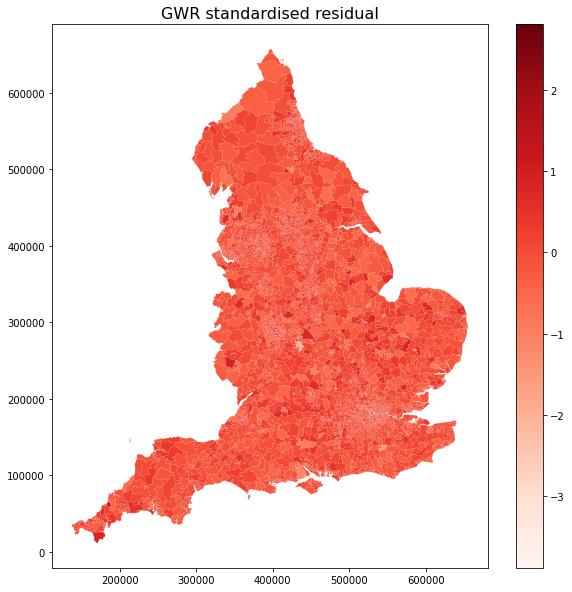

In [308]:
# visualise the residuals
# f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# # Flatten them
# ax = ax.flatten()

# (gdf_gwr_result
#  .sort_values('resid')
#  .plot('resid',
#        ax=ax,
#        legend=True,
#        vmin=np.min(gdf_gwr_result.resid),
#        vmax=np.max(gdf_gwr_result.resid),
#        cmap='Reds'))

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title('residual', fontsize=16)
    
# f.tight_layout()
    
# plt.show()

f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('GWR standardised residual', fontsize=16)
# gwr_resid = results.resid_response
gdf_gwr_result.plot('resid',
       ax=ax,
       legend=True,
       vmin=np.min(gdf_gwr_result.resid),
       vmax=np.max(gdf_gwr_result.resid),
       cmap='Reds')

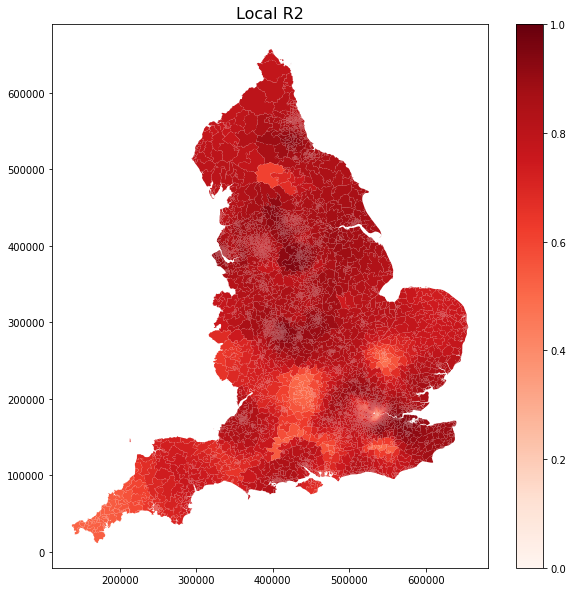

In [313]:
# R2
f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('Local R2', fontsize=16)
# gwr_resid = results.resid_response
# gdf_gwr_result.plot('resid',
#        ax=ax,
#        legend=True,
#        vmin=np.min(gdf_gwr_result.resid),
#        vmax=np.max(gdf_gwr_result.resid),
#        cmap='Reds')
# gdf_gwr_result.sort_values('localR2').plot('localR2',
# #        ax=ax[-1],
#        legend=True,
#        vmin=0,
#        vmax=1,
#        cmap='Reds')
gdf_gwr_result.plot('localR2',
       ax=ax,
       legend=True,
       vmin=0,
       vmax=1,
       cmap='Reds')
plt.savefig('../Images/GWR_local_R2.png', bbox_inches='tight')

In [ ]:
# For the last one, local R2, we can just map all of them regarding the significance

# (gdf_gwr_result
#  .sort_values('localR2')
#  .plot('localR2',
#        ax=ax[-1],
#        legend=True,
#        vmin=0,
#        vmax=1,
#        cmap='Reds'))
    
# ax[-1].set_xticklabels([])
# ax[-1].set_yticklabels([])
# ax[-1].set_xticks([])
# ax[-1].set_yticks([])
    
# ax[-1].set_title('Local R2', fontsize=16)

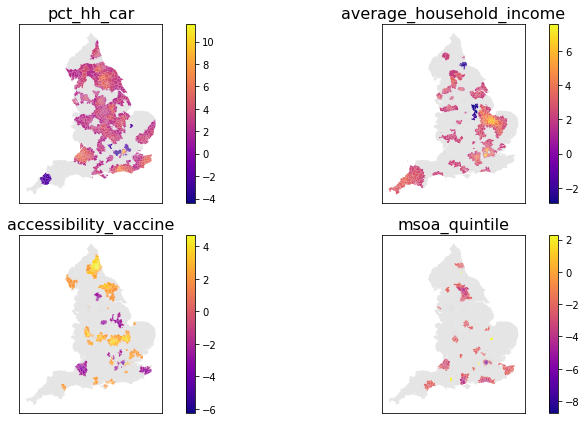

In [320]:
# GWR coefficients of IMD decile, hh_car, average_income, accessibility
f,ax=plt.subplots(2,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots and the variables to plot
titles = ['pct_hh_car', 'average_household_income', 'accessibility_vaccine', 'msoa_quintile']

# Here, we are creating loop for our parameter estimates 
# grey means coef of 0
for i,var in enumerate(titles):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
f.tight_layout()
    
# plt.show()
plt.savefig('../Images/GWR_coef_car_income_accessibility_imd_quintile.png', bbox_inches='tight')

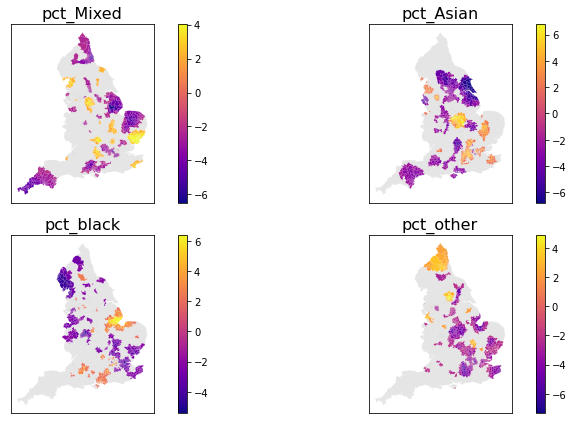

In [319]:
# Ethnic composition
f,ax=plt.subplots(2,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = [
#     'pct_hh_car',
 'pct_Mixed',
 'pct_Asian',
 'pct_black',
 'pct_other']

# Here, we are creating loop for our parameter estimates 
for i,var in enumerate(titles):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
 

    
f.tight_layout()
    
# plt.show()
plt.savefig('../Images/GWR_coef_ethnic_mixed_asian_black_other.png', bbox_inches='tight')

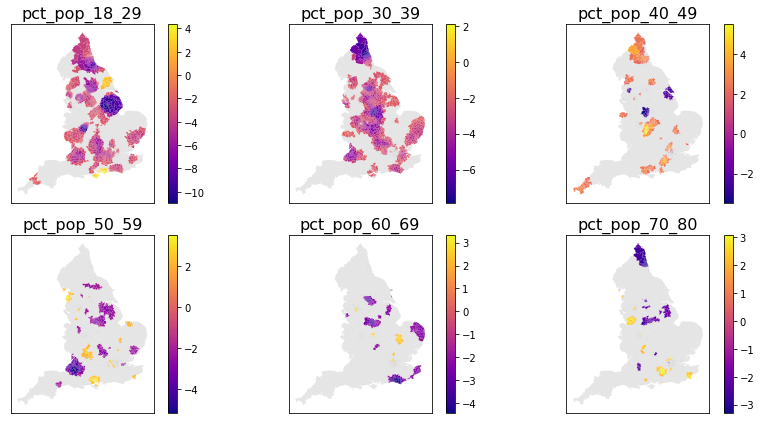

In [318]:
# GWR coefficients of age group population
f,ax=plt.subplots(2,3,figsize=(12,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots and the variables to plot
titles = ['pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80']

# Here, we are creating loop for our parameter estimates 
# grey means coef of 0
for i,var in enumerate(titles):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
f.tight_layout()
    
# plt.show()
plt.savefig('../Images/GWR_coef_pop_group.png')

# MGWR model (DEPRECATED)

This part will build a MGWR model using the following variables (same as GWR model):

- IMD decile
- Proportion of age group
- Ethnic composition
- Average household income
- Car ownership
- Accessibility

### Data preparation

In [103]:
# add coords to df_uptake by linking to gdf_england_no_London
if 'BNG_E' not in df_uptake.columns.values:
    df_uptake = df_uptake.merge(gdf_england[['MSOA11CD', 'BNG_E', 'BNG_N']], left_on = 'MSOA', right_on='MSOA11CD', how='left')
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile', 'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [104]:
list_x_var = ['msoa_quintile',
              'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80',
              'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other',
              'average_household_income',
              'pct_hh_car',
              'accessibility_vaccine'
             ]

In [105]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[list_x_var].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [106]:
print(g_X)

[[ 1.41369282 -0.13665474 -1.00854753 ...  1.28357132  0.86778636
   0.03733851]
 [ 1.41369282 -0.42141831 -1.13268903 ...  0.71943166  0.57413963
  -0.25172597]
 [ 1.41369282 -0.50536335 -0.32042746 ...  1.24254298  1.16321247
  -0.68862702]
 ...
 [-1.41410947 -0.4362239  -0.20431454 ... -1.13710069 -0.54423542
  -1.50477551]
 [-1.41410947 -0.12622205  0.2401436  ... -1.12684361 -0.21831319
  -1.44195021]
 [-1.41410947  0.06802551  0.27478173 ... -1.11658652 -0.32984285
  -1.4612767 ]]


### Select the bandwidth

In [108]:
# Calibrate MGWR model for the first 100 rows
max_ind = 100
# set it as None if all rows are used

mgwr_selector = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  multi=True)

In [110]:
%%time
mgwr_bw = mgwr_selector.search()
print(mgwr_bw)


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[95. 44. 99. 62. 99. 99. 62. 99. 61. 95. 99. 53. 99. 99. 99.]
CPU times: user 40min 17s, sys: 2h 17min 54s, total: 2h 58min 11s
Wall time: 11min 8s


In [111]:
# Calibrate MGWR model for the whole data
max_ind = None
# set it as None if all rows are used

mgwr_selector = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  multi=True)

In [114]:
%%time
mgwr_bw = mgwr_selector.search(bw_min=100, bw_max=150)
print(mgwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[  43.  233.  110.  110. 6183.  480. 6614.  989. 6786.  340. 3513.  738.
 6786. 6786. 6786.]
CPU times: user 5d 4h 45min 9s, sys: 14d 18h 1min 29s, total: 19d 22h 46min 38s
Wall time: 1d 5h 57min 16s


In [172]:
len(mgwr_bw.tolist())

15

In [173]:
len(list_x_var)

14

In [176]:
df_bandwidth = pd.DataFrame({'var' : ['Intercept'] + list_x_var, 'bandwidth' : mgwr_bw.tolist()})
print(df_bandwidth)

                         var  bandwidth
0                  Intercept       43.0
1              msoa_quintile      233.0
2              pct_pop_18_29      110.0
3              pct_pop_30_39      110.0
4              pct_pop_40_49     6183.0
5              pct_pop_50_59      480.0
6              pct_pop_60_69     6614.0
7              pct_pop_70_80      989.0
8                  pct_Mixed     6786.0
9                  pct_Asian      340.0
10                 pct_black     3513.0
11                 pct_other      738.0
12  average_household_income     6786.0
13                pct_hh_car     6786.0
14     accessibility_vaccine     6786.0


### Build the model

In [118]:
%%time
# build the MGWR model
results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1d 12h 35min 39s, sys: 3h 58min 25s, total: 1d 16h 34min 5s
Wall time: 3h 43min 57s


In [119]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                6787
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2035.450
Log-likelihood:                                                   -5543.570
AIC:                                                              11117.141
AICc:                                                             11119.221
BIC:                                                             -57712.310
R2:                                                                   0.700
Adj. R2:                                                              0.699

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Testing the spatial autocorrelation of residuals

In [120]:
results.resid_response

array([ 0.0381664 , -0.26344471,  0.37721717, ..., -0.25079931,
        0.16880804, -0.09703882])

In [121]:
import esda

In [122]:
mi = esda.moran.Moran(results.resid_response, w=wq, two_tailed=False)

# pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)

In [123]:
print("P value under normality assumption:")
print("%.5f"%mi.p_norm)
print("P value via permutation:")
print("%.5f"%mi.p_sim)
print("P value under randomization assumption:")
print("%.5f"%mi.p_rand)

P value under normality assumption:
0.42529
P value via permutation:
0.41700
P value under randomization assumption:
0.42525


From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we only include statistically significant estimates (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using filter_tval.

In [124]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### Visualising the results

In [127]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
# data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [128]:
list_x_var

['msoa_quintile',
 'pct_pop_18_29',
 'pct_pop_30_39',
 'pct_pop_40_49',
 'pct_pop_50_59',
 'pct_pop_60_69',
 'pct_pop_70_80',
 'pct_Mixed',
 'pct_Asian',
 'pct_black',
 'pct_other',
 'average_household_income',
 'pct_hh_car',
 'accessibility_vaccine']

In [133]:
# Create the new dataframe
df1=pd.DataFrame(df_uptake["MSOA"])
df2 = df1.assign(intercept=data_params[0],
                 msoa_quintile=data_params[1],
                 pct_pop_18_29=data_params[2],
                 pct_pop_30_39=data_params[3],
                 pct_pop_40_49=data_params[4],
                 pct_pop_50_59=data_params[5],
                 pct_pop_60_69=data_params[6],
                 pct_pop_70_80=data_params[7],
                 pct_Mixed=data_params[8],
                 pct_Asian=data_params[9],
                 pct_black=data_params[10],
                 pct_other=data_params[11],
                 average_household_income=data_params[12],
                 pct_hh_car=data_params[13],
                 accessibility_vaccine=data_params[14],
#                  eth_other=data_params[15],
                 resid = data_resid[0],
#                  localR2=data_localR2[0],
                )
df2.columns
df2

,MSOA,intercept,msoa_quintile,pct_pop_18_29,pct_pop_30_39,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_Mixed,pct_Asian,pct_black,pct_other,average_household_income,pct_hh_car,accessibility_vaccine,resid
0,E02002796,3.850442,-4.293238,0.000000,-7.426379,5.937199,0.0,0.0,0.0,-4.922298,0.000000,0.0,-6.481133,6.701150,15.116169,3.792404,0.038166
1,E02002797,4.420764,-4.197039,-1.973474,-7.677194,5.937521,0.0,0.0,0.0,-4.921852,0.000000,0.0,-6.449383,6.700425,15.115226,3.791272,-0.263445
2,E02002798,3.973252,-4.440838,0.000000,-7.531026,5.940079,0.0,0.0,0.0,-4.924429,0.000000,0.0,-6.504729,6.702783,15.116201,3.792774,0.377217
3,E02002799,4.333942,-4.354730,0.000000,-7.506685,5.939460,0.0,0.0,0.0,-4.923750,0.000000,0.0,-6.485494,6.702106,15.115816,3.792234,0.702932
4,E02002800,4.424859,-4.280262,0.000000,-7.546293,5.938453,0.0,0.0,0.0,-4.922747,0.000000,0.0,-6.466097,6.701214,15.115499,3.791720,-0.393753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6782,E02002478,0.000000,0.000000,0.000000,-5.791066,5.956370,0.0,0.0,0.0,-4.916009,-5.825984,0.0,-2.588507,6.708358,15.141967,3.814945,-0.068999
6783,E02002479,0.000000,0.000000,0.000000,-5.120848,5.955636,0.0,0.0,0.0,-4.913524,-5.502853,0.0,-2.503557,6.706224,15.141331,3.813986,-0.262911
6784,E02002480,0.000000,0.000000,0.000000,-5.763879,5.954598,0.0,0.0,0.0,-4.915216,-5.365295,0.0,-2.770378,6.707235,15.140895,3.814016,-0.250799
6785,E02002481,0.000000,0.000000,0.000000,-6.241270,5.954458,0.0,0.0,0.0,-4.915956,-5.244336,0.0,-2.831962,6.707771,15.140885,3.814159,0.168808


Merge the GWR results with the shapefile.

In [134]:
# Merge our shapefile with the model's results using left_join
gdf_gwr_result = gdf_england.merge(df2, left_on='MSOA11CD', right_on='MSOA')
gdf_gwr_result.head()

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,pct_pop_60_69,pct_pop_70_80,pct_Mixed,pct_Asian,pct_black,pct_other,average_household_income,pct_hh_car,accessibility_vaccine,resid
0,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,...,0.0,6.537170,-5.001804,4.107768,-4.701141,-6.787158,6.768314,15.101426,3.781229,0.127508
1,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.138149,51.57605,2.143568e+06,9118.196243,...,0.0,6.535955,-5.002047,4.107453,-4.701177,-6.821992,6.768693,15.101631,3.781372,-0.354550
2,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.176828,51.55638,2.491467e+06,8206.551627,...,0.0,6.545945,-5.002919,4.081505,-4.702250,-7.025008,6.769692,15.101909,3.781793,-0.188182
3,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.144267,51.56069,1.186053e+06,6949.688798,...,0.0,6.535926,-5.002476,4.102168,-4.701314,-6.886162,6.769296,15.101911,3.781608,0.301736
4,6,E02000007,Barking and Dagenham 006,Barking and Dagenham 006,549698,186609,0.158087,51.55850,1.733891e+06,6773.520925,...,0.0,6.539825,-5.002673,4.094156,-4.701702,-6.944962,6.769477,15.101917,3.781692,-0.140113


<AxesSubplot:title={'center':'GWR standardised residual'}>

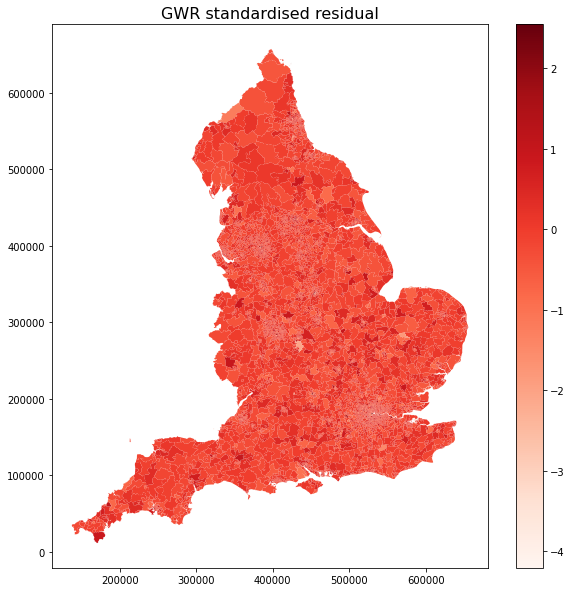

In [135]:
# visualise the residuals
# f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# # Flatten them
# ax = ax.flatten()

# (gdf_gwr_result
#  .sort_values('resid')
#  .plot('resid',
#        ax=ax,
#        legend=True,
#        vmin=np.min(gdf_gwr_result.resid),
#        vmax=np.max(gdf_gwr_result.resid),
#        cmap='Reds'))

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title('residual', fontsize=16)
    
# f.tight_layout()
    
# plt.show()

f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('MGWR standardised residual', fontsize=16)
# gwr_resid = results.resid_response
gdf_gwr_result.plot('resid',
       ax=ax,
       legend=True,
       vmin=np.min(gdf_gwr_result.resid),
       vmax=np.max(gdf_gwr_result.resid),
       cmap='Reds')

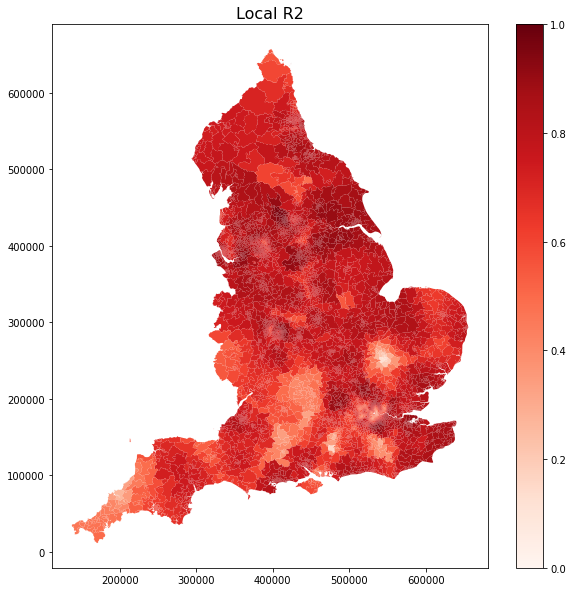

In [132]:
# R2
f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('Local R2', fontsize=16)
# gwr_resid = results.resid_response
# gdf_gwr_result.plot('resid',
#        ax=ax,
#        legend=True,
#        vmin=np.min(gdf_gwr_result.resid),
#        vmax=np.max(gdf_gwr_result.resid),
#        cmap='Reds')
# gdf_gwr_result.sort_values('localR2').plot('localR2',
# #        ax=ax[-1],
#        legend=True,
#        vmin=0,
#        vmax=1,
#        cmap='Reds')
gdf_gwr_result.plot('localR2',
       ax=ax,
       legend=True,
       vmin=0,
       vmax=1,
       cmap='Reds')
plt.savefig('../Images/MGWR_local_R2.png', bbox_inches='tight')

In [ ]:
# For the last one, local R2, we can just map all of them regarding the significance

# (gdf_gwr_result
#  .sort_values('localR2')
#  .plot('localR2',
#        ax=ax[-1],
#        legend=True,
#        vmin=0,
#        vmax=1,
#        cmap='Reds'))
    
# ax[-1].set_xticklabels([])
# ax[-1].set_yticklabels([])
# ax[-1].set_xticks([])
# ax[-1].set_yticks([])
    
# ax[-1].set_title('Local R2', fontsize=16)

In [139]:
titles = ['pct_hh_car', 'average_household_income', 'accessibility_vaccine', 'msoa_quintile']
labels = ['(a) %households owning cars', '(b) Average household income', '(c) Accessiblity score to vaccine', '(d) IMD quintile (1-5)']

# Here, we are creating loop for our parameter estimates 
# grey means coef of 0
for i,(var,label) in enumerate(zip(titles, labels)):
    print(label)

(a) %households owning cars
(b) Average household income
(c) Accessiblity score to vaccine
(d) IMD quintile (1-5)


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


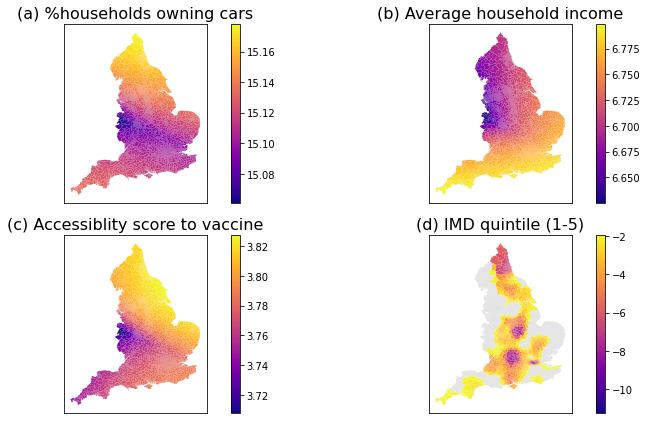

<Figure size 432x288 with 0 Axes>

In [177]:
# GWR coefficients of IMD decile, hh_car, average_income, accessibility
f,ax=plt.subplots(2,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots and the variables to plot
titles = ['pct_hh_car', 'average_household_income', 'accessibility_vaccine', 'msoa_quintile']
labels = ['(a) %households owning cars', '(b) Average household income', '(c) Accessiblity score to vaccine', '(d) IMD quintile (1-5)']

# Here, we are creating loop for our parameter estimates 
# grey means coef of 0
for i,(var,label) in enumerate(zip(titles, labels)):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True, 
#            title=label
          )
    )
    
    ax[i].set_title(label, fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
f.tight_layout()
    
plt.show()
plt.savefig('../Images/MGWR_coef_car_income_accessibility_imd_quintile.png', bbox_inches='tight')

In [159]:
def plot_ethnic_coef(b_same_value_range = True):
    f,ax=plt.subplots(2,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
    # Flatten them
    ax = ax.flatten()
    # Define the title of our plots
    titles = [
    #     'pct_hh_car',
     'pct_Mixed',
     'pct_Asian',
     'pct_black',
     'pct_other']

    labels = [
    #     'pct_hh_car',
     '% Mixed',
     '% Asian',
     '% Black',
     '% Other']

    # set both vmin and vmax as None.
    vmin_global, vmax_global = None, None

    # if b_same_value_range is True, then calculate the global min and max
    if b_same_value_range is True:
        vmin_global = gdf_gwr_result[titles].min().min()
        vmax_global = gdf_gwr_result[titles].max().min()
    #     list_min = []
    #     list_max = []
    #     # get vmin and vmax
    #     for var in titles:
    #         list_min.append(np.min(gdf_gwr_result[var]))
    #         list_max.append(np.max(gdf_gwr_result[var]))

    #     vmin_global = np.min(list_min)
    #     vmax_global = np.max(list_max)

    print(vmin_global)
    print(vmax_global)

    # Here, we are creating loop for our parameter estimates 
    for i,(var,label) in enumerate(zip(titles, labels)):
        # We want to plot all the non-significant estimates in grey
        ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
        (ct_temp.query('toplot==0')
         .sort_values('toplot')
         .plot(color='grey',ax=ax[i],alpha=.2))
        # and assign colours only to the significant estimates
        (ct_temp.query('toplot!=0')
         .sort_values('toplot')
         .plot('toplot',
               cmap='plasma',
               ax=ax[i],
               vmin = vmin_global,
               vmax = vmax_global,
               legend=True,
              )
        )

        ax[i].set_title(label, fontsize=16)

        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    f.tight_layout()
    # plt.show()
    # plt.savefig('../Images/GWR_coef_ethnic_mixed_asian_black_other.png', bbox_inches='tight')

-8.36217536090644
-4.8158914757762785


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


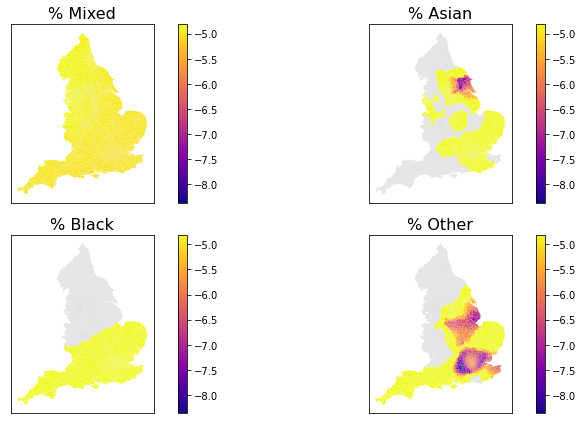

None
None


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

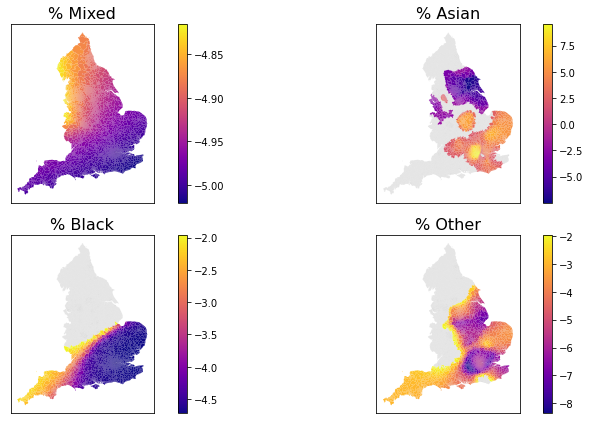

<Figure size 432x288 with 0 Axes>

In [178]:
# Ethnic composition

plot_ethnic_coef(b_same_value_range = True)
plt.show()
plt.savefig('../Images/MGWR_coef_ethnic_mixed_asian_black_other_1.png', bbox_inches='tight')
plot_ethnic_coef(b_same_value_range = False)
plt.show()
plt.savefig('../Images/MGWR_coef_ethnic_mixed_asian_black_other_2.png', bbox_inches='tight')

In [164]:
def plot_age_group_coef(b_same_value_range = True):
    f,ax=plt.subplots(2,3,figsize=(12,6), subplot_kw=dict(aspect='equal'))
    # Flatten them
    ax = ax.flatten()
    # Define the title of our plots and the variables to plot
    titles = ['pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80']
    labels = ['(a) % 18-29', '(b) % 30-39', '(c) % 40-49','(d) % 50-59', '(e) % 60-69', '(f) % 70-80']

    # set both vmin and vmax as None.
    vmin_global, vmax_global = None, None

    # if b_same_value_range is True, then calculate the global min and max
    if b_same_value_range is True:
        vmin_global = gdf_gwr_result[titles].min().min()
        vmax_global = gdf_gwr_result[titles].max().max()
    #     list_min = []
    #     list_max = []
    #     # get vmin and vmax
    #     for var in titles:
    #         list_min.append(np.min(gdf_gwr_result[var]))
    #         list_max.append(np.max(gdf_gwr_result[var]))

    #     vmin_global = np.min(list_min)
    #     vmax_global = np.max(list_max)

    print(vmin_global)
    print(vmax_global)

    # Here, we are creating loop for our parameter estimates 
    for i,(var,label) in enumerate(zip(titles, labels)):
        # We want to plot all the non-significant estimates in grey
        ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
        (ct_temp.query('toplot==0')
         .sort_values('toplot')
         .plot(color='grey',ax=ax[i],alpha=.2))
        # and assign colours only to the significant estimates
        (ct_temp.query('toplot!=0')
         .sort_values('toplot')
         .plot('toplot',
               cmap='plasma',
               ax=ax[i],
               vmin = vmin_global,
               vmax = vmax_global,
               legend=True,
              )
        )

        ax[i].set_title(label, fontsize=16)

        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    f.tight_layout()
    # plt.show()
    # plt.savefig('../Images/GWR_coef_ethnic_mixed_asian_black_other.png', bbox_inches='tight')

-14.67509609784927
0.0


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


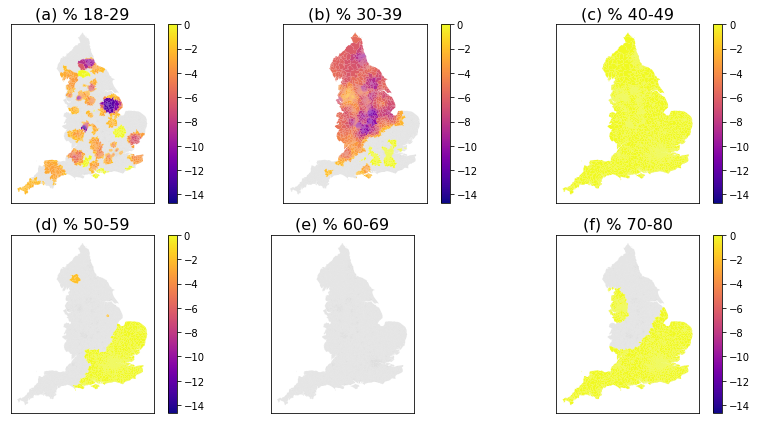

None
None


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

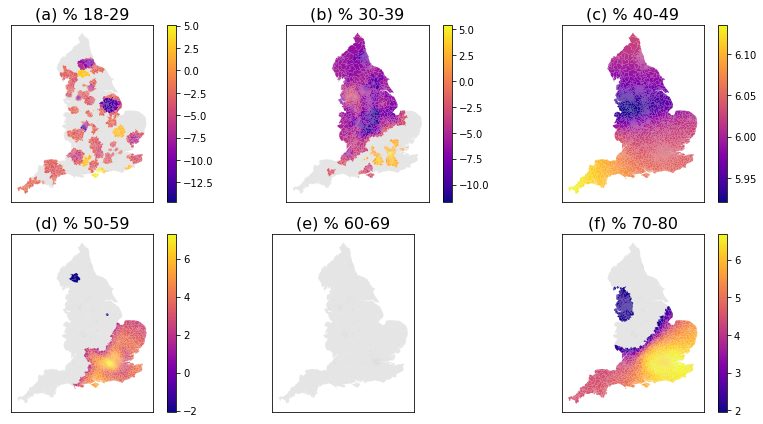

<Figure size 432x288 with 0 Axes>

In [179]:
# Age group

plot_age_group_coef(b_same_value_range = True)
plt.show()
plt.savefig('../Images/MGWR_coef_ethnic_age_group_1.png', bbox_inches='tight')
plot_age_group_coef(b_same_value_range = False)
plt.show()
plt.savefig('../Images/MGWR_coef_ethnic_age_group_2.png', bbox_inches='tight')

# Second MGWR model

This part will build a MGWR model using the following variables (same as GWR model):

- IMD decile
- Proportion of age group
- Ethnic composition
- Average household income
- Car ownership
- Accessibility

### Data preparation

In [75]:
# add coords to df_uptake by linking to gdf_england_no_London
if 'BNG_E' not in df_uptake.columns.values:
    df_uptake = df_uptake.merge(gdf_england[['MSOA11CD', 'BNG_E', 'BNG_N']], left_on = 'MSOA', right_on='MSOA11CD', how='left')
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile', 'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [82]:
df_uptake.mean(axis=0)

/tmp/ipykernel_18607/1714528005.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_uptake.mean(axis=0)


Unnamed: 0                          3393.000000
18over1st_dose                      5875.655813
18over2nd_dose                      5575.873435
pop0_17                             1781.063062
pop18over                           6545.808457
vaccination_percentage_1stdose         0.901363
vaccination_percentage_2nddose         0.858624
vaccination_percentage_total           0.880194
pct_pop_18_29                          0.017245
pct_pop_30_39                          0.190016
pct_pop_40_49                          0.198451
pct_pop_50_59                          0.213569
pct_pop_60_69                          0.167174
pct_pop_70_80                          0.134198
pct_pop_80_over                        0.079347
average_household_income           43886.002652
IMD19 SCORE                           21.591448
pct_White                              0.863413
pct_Mixed                              0.021840
pct_Asian                              0.072493
pct_black                              0

In [76]:
list_x_var = ['msoa_quintile',
              'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80',
              'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_White',
              'average_household_income',
              'pct_hh_car',
              'accessibility_vaccine'
             ]

In [106]:
list_x_var = ['msoa_quintile',
              'pct_pop_18_29', 
#               'pct_pop_30_39', 
              'pct_pop_40_49',
              'pct_pop_50_59', 
              'pct_pop_60_69', 
              'pct_pop_70_80', 
              'pct_pop_80_over',
              'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other',
              'average_household_income',
              'pct_hh_car',
              'accessibility_vaccine'
             ]

In [107]:
list_x_var

['msoa_quintile',
 'pct_pop_18_29',
 'pct_pop_40_49',
 'pct_pop_50_59',
 'pct_pop_60_69',
 'pct_pop_70_80',
 'pct_pop_80_over',
 'pct_Mixed',
 'pct_Asian',
 'pct_black',
 'pct_other',
 'average_household_income',
 'pct_hh_car',
 'accessibility_vaccine']

In [108]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[list_x_var].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [113]:
# OLS regression
ols = pysal.model.spreg.OLS(g_y, g_X, w = wq, 
                            spat_diag=True,
                            moran=True,
                            name_y='vaccine_uptake',
                            name_x=list_x_var,
                            name_ds='England', 
                            white_test=True)

# summary of OLS
df_ols_summary = pd.DataFrame({'AIC':[ols.aic], 'Adj_R2':[ols.ar2], 'RSS':[ols.utu], 'Log-likelihood':[ols.logll]})
display(df_ols_summary)

df_ols_result =pd.DataFrame({'Variable': ols.name_x, 'Coefficient' : ols.betas.flatten(),'Std.Error':ols.std_err.flatten(), 't-Statistic':[x[0] for x in ols.t_stat], 
                               'p-value':[x[1] for x in ols.t_stat]})
# vif
vif_ols = pysal.model.spreg.vif(ols)
vif_ols[0] = (np.nan, np.nan)
df_ols_result['VIF'] = [x[0] for x in vif_ols]
display(df_ols_result)

,AIC,Adj_R2,RSS,Log-likelihood
0,11117.140902,0.699476,2035.449906,-5543.570451


,Variable,Coefficient,Std.Error,t-Statistic,p-value,VIF
0,CONSTANT,-3.046836e-17,0.006655,-4.578427e-15,1.000000e+00,NaN
1,msoa_quintile,-3.570125e-02,0.014505,-2.461371e+00,1.386546e-02,4.750585
2,pct_pop_18_29,-1.669582e-01,0.007699,-2.168652e+01,6.983796e-101,1.338351
3,pct_pop_40_49,1.930723e-01,0.017052,1.132241e+01,1.867738e-29,6.565936
4,pct_pop_50_59,1.293320e-01,0.008868,1.458457e+01,1.836440e-47,1.775657
5,pct_pop_60_69,1.624228e-01,0.015611,1.040446e+01,3.658822e-25,5.502875
6,pct_pop_70_80,2.708510e-01,0.020774,1.303786e+01,2.154151e-38,9.745009
7,pct_pop_80_over,1.400802e-01,0.012662,1.106305e+01,3.302648e-28,3.620243
8,pct_Mixed,-1.261302e-01,0.014388,-8.766128e+00,2.308744e-18,4.674732
9,pct_Asian,3.729447e-02,0.009294,4.012789e+00,6.065226e-05,1.950431


### Select the bandwidth

In [242]:
# Calibrate MGWR model for the whole data
max_ind = None
# set it as None if all rows are used
# reference: https://mgwr.readthedocs.io/en/latest/generated/mgwr.sel_bw.Sel_BW.html

mgwr_selector = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  multi=True)

In [243]:
%%time
# mgwr_bw = mgwr_selector.search(multi_bw_max=[200])
mgwr_bw = mgwr_selector.search()
print(mgwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[  43.  207.  138.   94. 4121. 6124. 5760. 4244. 6786.  719. 3566. 1601.
 6786. 6786. 6786.]
CPU times: user 8d 16h 23min 29s, sys: 24d 6h 12min 58s, total: 32d 22h 36min 27s
Wall time: 2d 1h 28min 16s


In [270]:
import copy

In [271]:
# mgwr_selector_no_limit_max_bandwidth is the copy of mgwr_selector, for selecting bandwidth without max bandwidth limit
mgwr_selector_no_limit_max_bandwidth = copy.deepcopy(mgwr_selector)

In [244]:
df_bandwidth = pd.DataFrame({'var' : ['Intercept'] + list_x_var, 'bandwidth' : mgwr_bw.tolist()})
print(df_bandwidth)

                         var  bandwidth
0                  Intercept       43.0
1              msoa_quintile      207.0
2              pct_pop_18_29      138.0
3              pct_pop_30_39       94.0
4              pct_pop_40_49     4121.0
5              pct_pop_50_59     6124.0
6              pct_pop_60_69     5760.0
7              pct_pop_70_80     4244.0
8                  pct_Mixed     6786.0
9                  pct_Asian      719.0
10                 pct_black     3566.0
11                 pct_White     1601.0
12  average_household_income     6786.0
13                pct_hh_car     6786.0
14     accessibility_vaccine     6786.0


### Build the model

In [245]:
%%time
# build the MGWR model
results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1d 15h 18min 27s, sys: 6h 16min 25s, total: 1d 21h 34min 52s
Wall time: 4h 16min 58s


In [246]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                6787
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2035.447
Log-likelihood:                                                   -5543.566
AIC:                                                              11117.132
AICc:                                                             11119.213
BIC:                                                             -57712.312
R2:                                                                   0.700
Adj. R2:                                                              0.699

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Testing the spatial autocorrelation of residuals

In [247]:
results.resid_response

array([ 0.0770306 , -0.33197662,  0.42018835, ..., -0.2405442 ,
        0.10783626, -0.08018953])

In [248]:
mi = esda.moran.Moran(results.resid_response, w=wq, two_tailed=False)

# pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)

In [249]:
print("P value under normality assumption:")
print("%.5f"%mi.p_norm)
print("P value via permutation:")
print("%.5f"%mi.p_sim)
print("P value under randomization assumption:")
print("%.5f"%mi.p_rand)

P value under normality assumption:
0.26508
P value via permutation:
0.26100
P value under randomization assumption:
0.26494


From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we only include statistically significant estimates (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using filter_tval.

In [250]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### Visualising the results

In [251]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
# data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [252]:
list_x_var

['msoa_quintile',
 'pct_pop_18_29',
 'pct_pop_30_39',
 'pct_pop_40_49',
 'pct_pop_50_59',
 'pct_pop_60_69',
 'pct_pop_70_80',
 'pct_Mixed',
 'pct_Asian',
 'pct_black',
 'pct_White',
 'average_household_income',
 'pct_hh_car',
 'accessibility_vaccine']

In [253]:
# Create the new dataframe
df1=pd.DataFrame(df_uptake["MSOA"])
df2 = df1.assign(intercept=data_params[0],
                 msoa_quintile=data_params[1],
                 pct_pop_18_29=data_params[2],
                 pct_pop_30_39=data_params[3],
                 pct_pop_40_49=data_params[4],
                 pct_pop_50_59=data_params[5],
                 pct_pop_60_69=data_params[6],
                 pct_pop_70_80=data_params[7],
                 pct_Mixed=data_params[8],
                 pct_Asian=data_params[9],
                 pct_black=data_params[10],
                 pct_White=data_params[11],
                 average_household_income=data_params[12],
                 pct_hh_car=data_params[13],
                 accessibility_vaccine=data_params[14],
#                  eth_other=data_params[15],
                 resid = data_resid[0],
#                  localR2=data_localR2[0],
                )
df2.columns
df2

,MSOA,intercept,msoa_quintile,pct_pop_18_29,pct_pop_30_39,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_Mixed,pct_Asian,pct_black,pct_White,average_household_income,pct_hh_car,accessibility_vaccine,resid
0,E02002796,3.321646,-4.337452,0.000000,-9.663657,2.799917,-2.954758,-4.226431,-2.114431,0.0,4.389350,4.276115,4.599032,6.379542,18.798834,3.368177,0.077031
1,E02002797,3.600429,-4.168612,-2.150302,-9.877146,2.805874,-2.955457,-4.220458,-2.111704,0.0,4.389128,4.282710,4.605366,6.378970,18.797821,3.367177,-0.331977
2,E02002798,3.657851,-4.499858,0.000000,-9.842967,2.806907,-2.932357,-4.209252,-2.108348,0.0,4.510443,4.300163,4.605903,6.380580,18.802726,3.368615,0.420188
3,E02002799,3.751873,-4.389203,0.000000,-9.837961,2.807631,-2.938003,-4.210811,-2.108809,0.0,4.487594,4.296133,4.607038,6.380105,18.801404,3.368112,0.795759
4,E02002800,3.685982,-4.274474,-1.978707,-9.819150,2.806612,-2.947114,-4.216053,-2.110390,0.0,4.440001,4.288712,4.606317,6.379502,18.799509,3.367613,-0.283787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6782,E02002478,0.000000,0.000000,0.000000,-5.856845,2.698639,-3.035792,-4.494972,-2.254486,0.0,2.856844,3.899904,3.791122,6.388582,18.794096,3.386832,-0.118377
6783,E02002479,0.000000,0.000000,0.000000,-5.834078,2.706147,-3.047016,-4.497596,-2.255109,0.0,2.869995,3.898514,3.771379,6.387135,18.789290,3.385900,-0.225695
6784,E02002480,0.000000,0.000000,0.000000,-5.346976,2.697226,-3.038317,-4.487667,-2.249155,0.0,2.862203,3.905195,3.789490,6.387651,18.792296,3.386026,-0.240544
6785,E02002481,0.000000,0.000000,0.000000,-6.648392,2.694037,-3.034660,-4.485263,-2.247543,0.0,2.859742,3.907240,3.796640,6.387977,18.793665,3.386186,0.107836


Merge the GWR results with the shapefile.

In [254]:
# Merge our shapefile with the model's results using left_join
gdf_gwr_result = gdf_england.merge(df2, left_on='MSOA11CD', right_on='MSOA')
gdf_gwr_result.head()

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,pct_pop_60_69,pct_pop_70_80,pct_Mixed,pct_Asian,pct_black,pct_White,average_household_income,pct_hh_car,accessibility_vaccine,resid
0,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,...,-3.079164,0.0,0.0,6.547657,5.393616,6.496689,6.427906,18.945641,3.359197,-0.001442
1,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.138149,51.57605,2.143568e+06,9118.196243,...,-3.078037,0.0,0.0,6.548250,5.393557,6.496585,6.428309,18.946321,3.359243,-0.349281
2,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.176828,51.55638,2.491467e+06,8206.551627,...,-3.075369,0.0,0.0,6.549370,5.393053,6.497225,6.429068,18.948023,3.359579,-0.344911
3,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.144267,51.56069,1.186053e+06,6949.688798,...,-3.075625,0.0,0.0,6.549054,5.393312,6.496568,6.428897,18.947387,3.359355,0.278530
4,6,E02000007,Barking and Dagenham 006,Barking and Dagenham 006,549698,186609,0.158087,51.55850,1.733891e+06,6773.520925,...,-3.075415,0.0,0.0,6.549320,5.393179,6.496803,6.428983,18.947681,3.359452,-0.127936


<AxesSubplot:title={'center':'MGWR standardised residual'}>

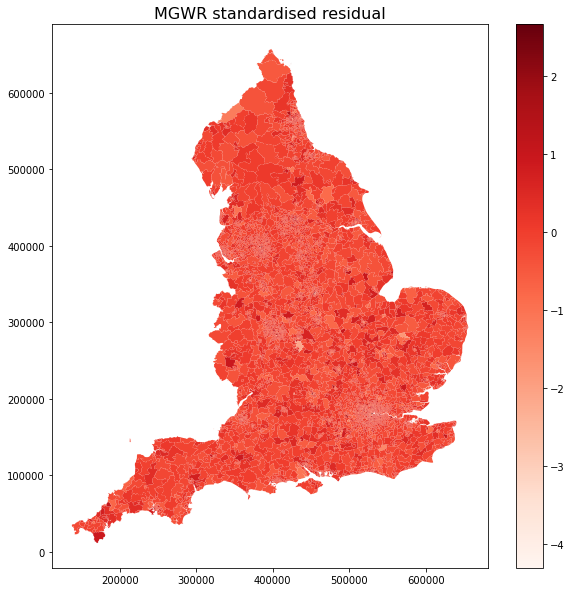

In [255]:
# visualise the residuals
# f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# # Flatten them
# ax = ax.flatten()

# (gdf_gwr_result
#  .sort_values('resid')
#  .plot('resid',
#        ax=ax,
#        legend=True,
#        vmin=np.min(gdf_gwr_result.resid),
#        vmax=np.max(gdf_gwr_result.resid),
#        cmap='Reds'))

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title('residual', fontsize=16)
    
# f.tight_layout()
    
# plt.show()

f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('MGWR standardised residual', fontsize=16)
# gwr_resid = results.resid_response
gdf_gwr_result.plot('resid',
       ax=ax,
       legend=True,
       vmin=np.min(gdf_gwr_result.resid),
       vmax=np.max(gdf_gwr_result.resid),
       cmap='Reds')

In [ ]:
# For the last one, local R2, we can just map all of them regarding the significance

# (gdf_gwr_result
#  .sort_values('localR2')
#  .plot('localR2',
#        ax=ax[-1],
#        legend=True,
#        vmin=0,
#        vmax=1,
#        cmap='Reds'))
    
# ax[-1].set_xticklabels([])
# ax[-1].set_yticklabels([])
# ax[-1].set_xticks([])
# ax[-1].set_yticks([])
    
# ax[-1].set_title('Local R2', fontsize=16)

/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


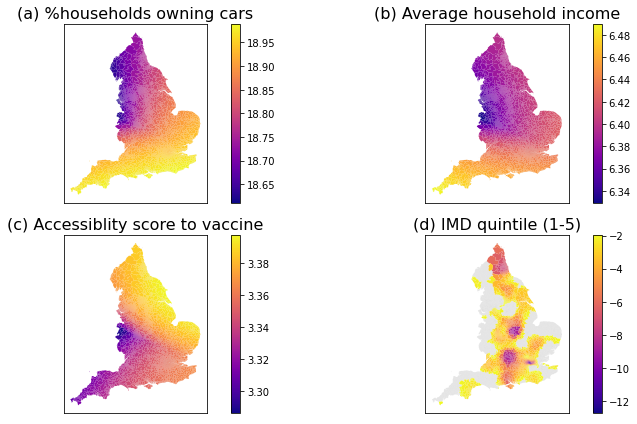

<Figure size 432x288 with 0 Axes>

In [256]:
# GWR coefficients of IMD decile, hh_car, average_income, accessibility
f,ax=plt.subplots(2,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots and the variables to plot
titles = ['pct_hh_car', 'average_household_income', 'accessibility_vaccine', 'msoa_quintile']
labels = ['(a) %households owning cars', '(b) Average household income', '(c) Accessiblity score to vaccine', '(d) IMD quintile (1-5)']

# Here, we are creating loop for our parameter estimates 
# grey means coef of 0
for i,(var,label) in enumerate(zip(titles, labels)):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True, 
#            title=label
          )
    )
    
    ax[i].set_title(label, fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
f.tight_layout()
    
plt.show()
plt.savefig('../Images/MGWR_max_bandwidth_200_coef_car_income_accessibility_imd_quintile.png', bbox_inches='tight')

In [257]:
def plot_ethnic_coef(b_same_value_range = True):
    f,ax=plt.subplots(2,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
    # Flatten them
    ax = ax.flatten()
    # Define the title of our plots
    titles = [
    #     'pct_hh_car',
     'pct_Mixed',
     'pct_Asian',
     'pct_black',
     'pct_White']

    labels = [
    #     'pct_hh_car',
     '% Mixed',
     '% Asian',
     '% Black',
     '% White']

    # set both vmin and vmax as None.
    vmin_global, vmax_global = None, None

    # if b_same_value_range is True, then calculate the global min and max
    if b_same_value_range is True:
        vmin_global = gdf_gwr_result[titles].min().min()
        vmax_global = gdf_gwr_result[titles].max().max()
    #     list_min = []
    #     list_max = []
    #     # get vmin and vmax
    #     for var in titles:
    #         list_min.append(np.min(gdf_gwr_result[var]))
    #         list_max.append(np.max(gdf_gwr_result[var]))

    #     vmin_global = np.min(list_min)
    #     vmax_global = np.max(list_max)

    print(vmin_global)
    print(vmax_global)

    # Here, we are creating loop for our parameter estimates 
    for i,(var,label) in enumerate(zip(titles, labels)):
        # We want to plot all the non-significant estimates in grey
        ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
        (ct_temp.query('toplot==0')
         .sort_values('toplot')
         .plot(color='grey',ax=ax[i],alpha=.2))
        # and assign colours only to the significant estimates
        (ct_temp.query('toplot!=0')
         .sort_values('toplot')
         .plot('toplot',
               cmap='plasma',
               ax=ax[i],
               vmin = vmin_global,
               vmax = vmax_global,
               legend=True,
              )
        )

        ax[i].set_title(label, fontsize=16)

        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    f.tight_layout()
    # plt.show()
    # plt.savefig('../Images/GWR_coef_ethnic_mixed_asian_black_other.png', bbox_inches='tight')

In [278]:
# check the range of coefficients of pct_Mixed
gdf_gwr_result.pct_Mixed.min()

0.0

0.0
7.427487358933988


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


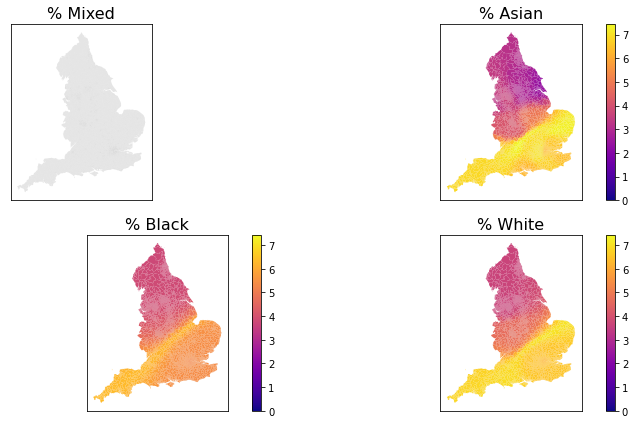

None
None


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

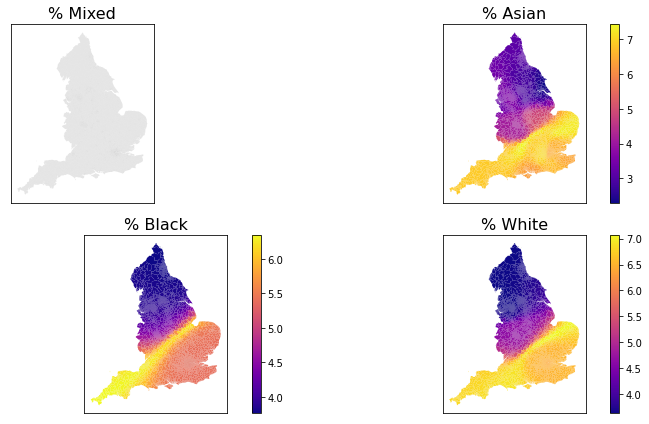

<Figure size 432x288 with 0 Axes>

In [258]:
# Ethnic composition

plot_ethnic_coef(b_same_value_range = True)
plt.show()
plt.savefig('../Images/MGWR_max_bandwidth_200_coef_ethnic_mixed_asian_black_other_1.png', bbox_inches='tight')
plot_ethnic_coef(b_same_value_range = False)
plt.show()
plt.savefig('../Images/MGWR_max_bandwidth_200_coef_ethnic_mixed_asian_black_other_2.png', bbox_inches='tight')

In [259]:
def plot_age_group_coef(b_same_value_range = True):
    f,ax=plt.subplots(2,3,figsize=(12,6), subplot_kw=dict(aspect='equal'))
    # Flatten them
    ax = ax.flatten()
    # Define the title of our plots and the variables to plot
    titles = ['pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80']
    labels = ['(a) % 18-29', '(b) % 30-39', '(c) % 40-49','(d) % 50-59', '(e) % 60-69', '(f) % 70-80']

    # set both vmin and vmax as None.
    vmin_global, vmax_global = None, None

    # if b_same_value_range is True, then calculate the global min and max
    if b_same_value_range is True:
        vmin_global = gdf_gwr_result[titles].min().min()
        vmax_global = gdf_gwr_result[titles].max().max()

    print(vmin_global)
    print(vmax_global)
    
    
    # Here, we are creating loop for our parameter estimates 
    for i,(var,label) in enumerate(zip(titles, labels)):
        # We want to plot all the non-significant estimates in grey
        ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
        (ct_temp.query('toplot==0')
         .sort_values('toplot')
         .plot(color='grey',ax=ax[i],alpha=.2))
        # and assign colours only to the significant estimates
        (ct_temp.query('toplot!=0')
         .sort_values('toplot')
         .plot('toplot',
               cmap='plasma',
               ax=ax[i],
               vmin = vmin_global,
               vmax = vmax_global,
               legend=True,
              )
        )

        ax[i].set_title(label, fontsize=16)

        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    f.tight_layout()
    # plt.show()
    # plt.savefig('../Images/GWR_coef_ethnic_mixed_asian_black_other.png', bbox_inches='tight')

In [287]:
def plot_age_group_coef_custom_legend(b_same_value_range = True):
    f,ax=plt.subplots(2,3,figsize=(12,6), subplot_kw=dict(aspect='equal'))
    # Flatten them
    ax = ax.flatten()
    # Define the title of our plots and the variables to plot
    titles = ['pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80']
    labels = ['(a) % 18-29', '(b) % 30-39', '(c) % 40-49','(d) % 50-59', '(e) % 60-69', '(f) % 70-80']

    # set both vmin and vmax as None.
    vmin_global, vmax_global = None, None

    # if b_same_value_range is True, then calculate the global min and max
    if b_same_value_range is True:
        vmin_global = gdf_gwr_result[titles].min().min()
        vmax_global = gdf_gwr_result[titles].max().max()
        if (vmin_global * vmax_global) < 0:
            divnorm=colors.TwoSlopeNorm(vmin=vmin_global, vcenter=0, vmax=vmax_global)
        else:
            divnorm=colors.TwoSlopeNorm(vmin=vmin_global, vmax=vmax_global, vcenter = (vmin_global+vmax_global)/2.0)
    else:
        divnorm = None
        
    print(vmin_global)
    print(vmax_global)
        
    # Here, we are creating loop for our parameter estimates 
    for i,(var,label) in enumerate(zip(titles, labels)):
        # We want to plot all the non-significant estimates in grey
        ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
        (ct_temp.query('toplot==0')
         .sort_values('toplot')
         .plot(color='grey',ax=ax[i],alpha=.2))
        # and assign colours only to the significant estimates
        (ct_temp.query('toplot!=0')
         .sort_values('toplot')
         .plot('toplot',
#                cmap='plasma',
               cmap='bwr', 
               norm=divnorm,
               ax=ax[i],
#                vmin = vmin_global,
#                vmax = vmax_global,
               legend=True,
              )
        )

        ax[i].set_title(label, fontsize=16)

        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    f.tight_layout()
    # plt.show()
    # plt.savefig('../Images/GWR_coef_ethnic_mixed_asian_black_other.png', bbox_inches='tight')

-15.242636468226719
3.8806006367703025


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


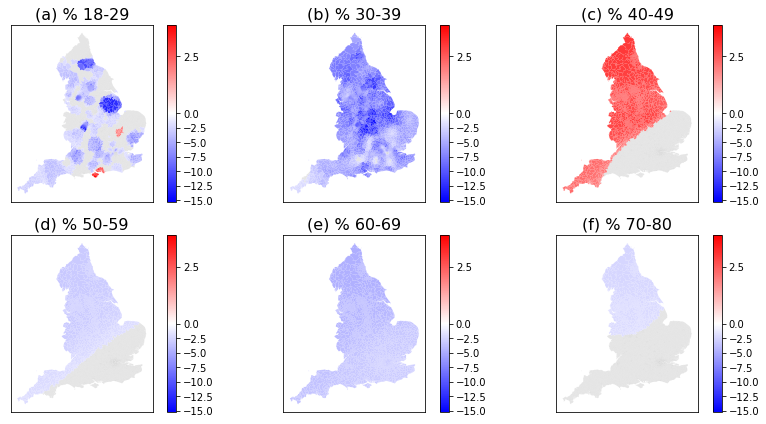

None
None


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


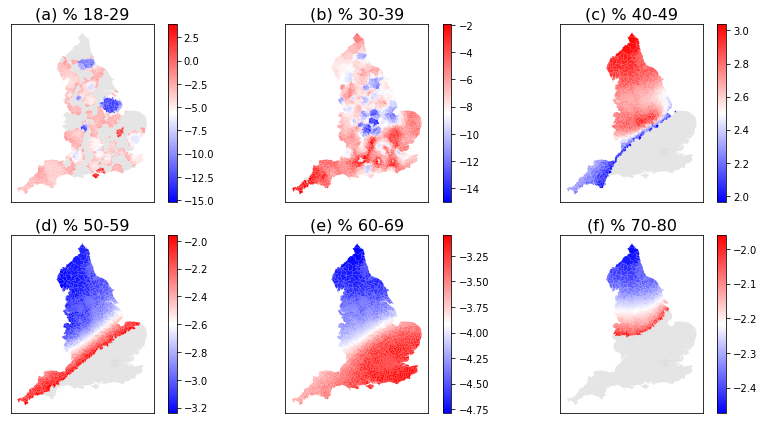

In [288]:
# Age group
plot_age_group_coef_custom_legend(b_same_value_range = True)
plt.show()
plot_age_group_coef_custom_legend(b_same_value_range = False)
plt.show()

-15.242636468226719
3.8806006367703025


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


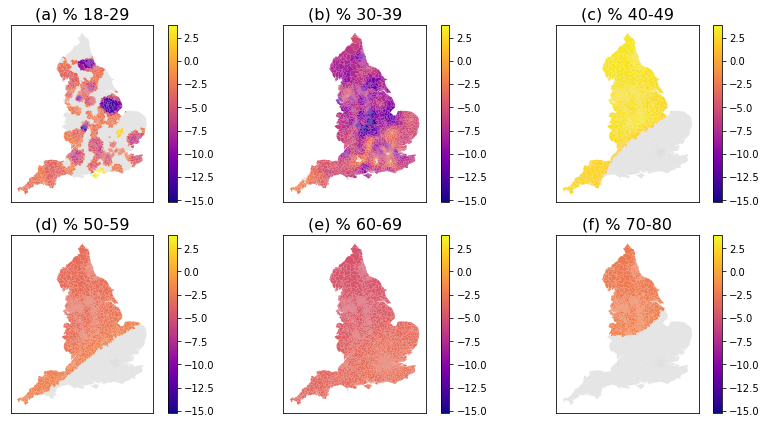

None
None


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

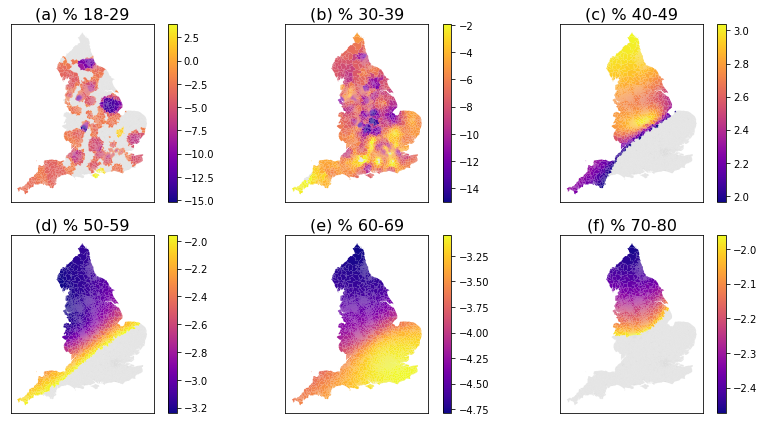

<Figure size 432x288 with 0 Axes>

In [260]:
# Age group

plot_age_group_coef(b_same_value_range = True)
plt.show()
plt.savefig('../Images/MGWR_max_bandwidth_200_coef_ethnic_age_group_1.png', bbox_inches='tight')
plot_age_group_coef(b_same_value_range = False)
plt.show()
plt.savefig('../Images/MGWR_max_bandwidth_200_coef_ethnic_age_group_2.png', bbox_inches='tight')

# First RF model

Using RF to study the relationship between vaccine uptake rates and socioeconomic variables and accessibility scores.

London is excluded. But in later experiment, London would be included if the travel duration combines private and public transport.

In [226]:
list_x_var_incl_access = ['employ_score' , 'edu_score' , 'health_score' , 'crime_score' , 'housing_score' , 'livEnv_score' ,
 'pct_hh_car' , 'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other', 'accessibility_vaccine']

In [227]:
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile', 'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [229]:
df_vaccine_excl_london = df_uptake[df_uptake.MSOA.isin(df_msoa_excl_london.MSOA11CD)]
# data split
train_x, test_x, train_y, test_y = train_test_split(df_vaccine_excl_london[list_x_var_incl_access], df_vaccine_excl_london.vaccination_percentage_2nddose)

In [230]:
print(train_x.shape)
print(train_y.shape)

(4354, 12)
(4354,)


In [231]:
# build a random forest
random_state_rf = 1024
rf_reg = RandomForestRegressor(random_state=random_state_rf)
# accuracy
rf_reg.fit(train_x, train_y)
# 
print("R2 on the training data:")
print(rf_reg.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_reg.score(X=test_x, y=test_y))

print("RMSE on the training data:")
print(mean_squared_error(train_y, rf_reg.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_reg.predict(test_x), squared=False))

R2 on the training data:
0.9619507048529488
R2 on the testing data:
0.6768877092784007
RMSE on the training data:
0.0191835986831157
RMSE on the testing data:
0.04945712259234904


                       Importance
Feature                          
pct_hh_car               0.957311
employ_score             0.729793
edu_score                0.105898
pct_other                0.037426
pct_Asian                0.034479
pct_black                0.034276
pct_Mixed                0.025463
health_score             0.023863
accessibility_vaccine    0.009829
crime_score              0.008410
livEnv_score             0.006167
housing_score            0.004203


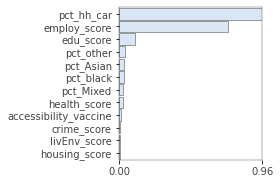

In [232]:
# feature importance
import rfpimp
imp = rfpimp.importances(rf_reg, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [137]:
feature_name_accessibility = 'accessibility_vaccine'
ind_accessibility = list_x_var_incl_access.index('accessibility_vaccine')
ind_pct_hh_car = list_x_var_incl_access.index('pct_hh_car')
ind_employ_score = list_x_var_incl_access.index('employ_score')

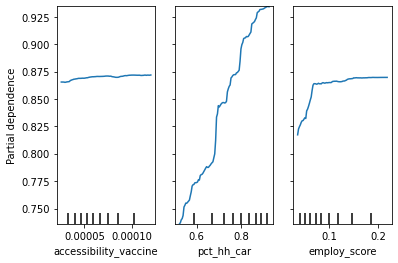

In [138]:
# partial dependence plot
# pd_result = partial_dependence(rf_reg, features=[ind_accessibility], X=train_x, kind='average')
PartialDependenceDisplay.from_estimator(rf_reg, train_x, [ind_accessibility, ind_pct_hh_car, ind_employ_score], kind='average')

# Second RF model

Using RF to study the relationship between vaccine uptake rates and socioeconomic variables and accessibility scores.

London is excluded. But in later experiment, London would be included if the travel duration combines private and public transport.

In [233]:
list_x_var_incl_access = ['msoa_quintile' , 'average_household_income', 
                          'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
 'pct_hh_car' , 
                          'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other', 'accessibility_vaccine']

In [234]:
df_vaccine_excl_london[list_x_var_incl_access].corr()

,msoa_quintile,average_household_income,pct_pop_18_29,pct_pop_30_39,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_pop_80_over,pct_hh_car,pct_Mixed,pct_Asian,pct_black,pct_other,accessibility_vaccine
msoa_quintile,1.000000,0.803637,-0.173217,-0.497621,-0.151437,0.142064,0.230660,0.421896,0.403079,0.790874,-0.309778,-0.258433,-0.323394,-0.223794,-0.260896
average_household_income,0.803637,1.000000,-0.137891,-0.274664,0.151300,0.188397,0.009891,0.134809,0.138302,0.717367,-0.081261,-0.144515,-0.177822,-0.106561,-0.242514
pct_pop_18_29,-0.173217,-0.137891,1.000000,0.386360,0.271308,-0.282887,-0.400734,-0.408884,-0.310924,-0.349411,0.333934,0.387859,0.296864,0.389711,0.149532
pct_pop_30_39,-0.497621,-0.274664,0.386360,1.000000,0.679467,-0.433857,-0.826295,-0.886729,-0.727932,-0.670293,0.607016,0.468682,0.536767,0.525089,0.301622
pct_pop_40_49,-0.151437,0.151300,0.271308,0.679467,1.000000,-0.101780,-0.789744,-0.840305,-0.701224,-0.304521,0.564558,0.494790,0.458993,0.400953,0.180061
pct_pop_50_59,0.142064,0.188397,-0.282887,-0.433857,-0.101780,1.000000,0.335186,0.124886,-0.084125,0.344259,-0.264629,-0.363907,-0.270726,-0.387775,-0.188681
pct_pop_60_69,0.230660,0.009891,-0.400734,-0.826295,-0.789744,0.335186,1.000000,0.792831,0.504991,0.470202,-0.608673,-0.442798,-0.502820,-0.480253,-0.217920
pct_pop_70_80,0.421896,0.134809,-0.408884,-0.886729,-0.840305,0.124886,0.792831,1.000000,0.772652,0.580250,-0.623342,-0.496069,-0.518127,-0.480245,-0.289548
pct_pop_80_over,0.403079,0.138302,-0.310924,-0.727932,-0.701224,-0.084125,0.504991,0.772652,1.000000,0.405212,-0.421077,-0.324499,-0.381928,-0.307973,-0.157320
pct_hh_car,0.790874,0.717367,-0.349411,-0.670293,-0.304521,0.344259,0.470202,0.580250,0.405212,1.000000,-0.484253,-0.350864,-0.452866,-0.435830,-0.361671


In [235]:
df_vaccine_excl_london.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile', 'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [237]:
df_vaccine_excl_london = df_uptake[df_uptake.MSOA.isin(df_msoa_excl_london.MSOA11CD)]
# data split
train_x, test_x, train_y, test_y = train_test_split(df_vaccine_excl_london[list_x_var_incl_access], df_vaccine_excl_london.vaccination_percentage_2nddose)

In [238]:
print(train_x.shape)
print(train_y.shape)

(4354, 15)
(4354,)


In [239]:
# build a random forest
random_state_rf = 1024
rf_reg = RandomForestRegressor(random_state=random_state_rf)
# accuracy
rf_reg.fit(train_x, train_y)
# 
print("R2 on the training data:")
print(rf_reg.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_reg.score(X=test_x, y=test_y))

print("RMSE on the training data:")
print(mean_squared_error(train_y, rf_reg.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_reg.predict(test_x), squared=False))

R2 on the training data:
0.9621174487525429
R2 on the testing data:
0.7404040792541342
RMSE on the training data:
0.01837736129557004
RMSE on the testing data:
0.05057452942085268


                          Importance
Feature                             
pct_hh_car                  0.410581
pct_pop_30_39               0.131461
average_household_income    0.044957
pct_pop_18_29               0.024439
pct_pop_50_59               0.013409
pct_pop_40_49               0.010587
pct_pop_70_80               0.010034
accessibility_vaccine       0.008734
pct_black                   0.008251
pct_pop_60_69               0.006631
msoa_quintile               0.006528
pct_Mixed                   0.006188
pct_other                   0.005454
pct_Asian                   0.004923
pct_pop_80_over             0.003349


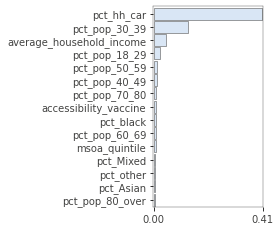

In [240]:
# feature importance
import rfpimp
imp = rfpimp.importances(rf_reg, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [241]:
feature_name_accessibility = 'accessibility_vaccine'
ind_accessibility = list_x_var_incl_access.index('accessibility_vaccine')
ind_pct_hh_car = list_x_var_incl_access.index('pct_hh_car')
ind_average_household_income = list_x_var_incl_access.index('average_household_income')
ind_pct_pop_30_39 = list_x_var_incl_access.index('pct_pop_30_39')

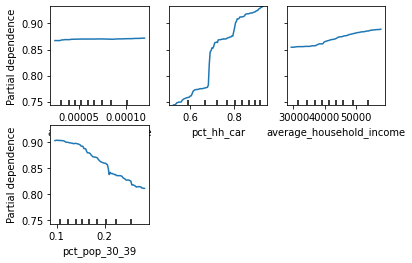

In [242]:
# partial dependence plot
# pd_result = partial_dependence(rf_reg, features=[ind_accessibility], X=train_x, kind='average')
PartialDependenceDisplay.from_estimator(rf_reg, train_x, [ind_accessibility, ind_pct_hh_car, ind_average_household_income, ind_pct_pop_30_39], kind='average')

# Third RF model

Main conclusion: the following three variables are among the most important features for this RF.
- pct_pop_18_29
- pct_pop_30_39
- pct_hh_car

Using RF to study the relationship between vaccine uptake rates and socioeconomic variables and accessibility scores.

London is excluded. But in later experiment, London would be included if the travel duration combines private and public transport.

In [149]:
list_x_var_incl_access = ['employ_score' , 'edu_score' , 'health_score' , 'crime_score' , 'housing_score' , 'livEnv_score' ,
                          'average_household_income', 
                          'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
 'pct_hh_car' , 
                          'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other', 'accessibility_vaccine']

In [150]:
df_vaccine_excl_london[list_x_var_incl_access].corr()

,employ_score,edu_score,health_score,crime_score,housing_score,livEnv_score,average_household_income,pct_pop_18_29,pct_pop_30_39,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_pop_80_over,pct_hh_car,pct_Mixed,pct_Asian,pct_black,pct_other,accessibility_vaccine
employ_score,1.000000,0.865337,0.879273,0.711136,-0.182089,0.212758,-0.794055,0.101684,0.381772,0.124275,-0.069472,-0.159834,-0.346526,-0.322353,-0.813353,0.239168,0.192175,0.270250,0.168815,0.246407
edu_score,0.865337,1.000000,0.761143,0.668862,-0.088672,0.162026,-0.747063,0.185922,0.456685,0.182093,-0.102304,-0.240834,-0.403463,-0.397752,-0.729780,0.237959,0.214662,0.266200,0.139688,0.197255
health_score,0.879273,0.761143,1.000000,0.719961,-0.273840,0.265058,-0.841302,0.157938,0.467715,0.077864,-0.172561,-0.193416,-0.362699,-0.344579,-0.814861,0.239783,0.196352,0.257309,0.211525,0.298243
crime_score,0.711136,0.668862,0.719961,1.000000,-0.197744,0.254885,-0.556140,0.205974,0.610509,0.363698,-0.167350,-0.445483,-0.574409,-0.459442,-0.765821,0.415934,0.276437,0.344435,0.297486,0.261828
housing_score,-0.182089,-0.088672,-0.273840,-0.197744,1.000000,0.176963,0.204767,0.096155,-0.015902,0.024990,-0.001061,0.035131,0.002858,-0.065398,0.181467,0.197131,0.106971,0.263299,0.143787,-0.076180
livEnv_score,0.212758,0.162026,0.265058,0.254885,0.176963,1.000000,-0.274439,0.183162,0.258952,0.081916,-0.097889,-0.112974,-0.227140,-0.222808,-0.333868,0.255913,0.304861,0.225373,0.259375,0.115645
average_household_income,-0.794055,-0.747063,-0.841302,-0.556140,0.204767,-0.274439,1.000000,-0.137891,-0.274664,0.151300,0.188397,0.009891,0.134809,0.138302,0.717367,-0.081261,-0.144515,-0.177822,-0.106561,-0.242514
pct_pop_18_29,0.101684,0.185922,0.157938,0.205974,0.096155,0.183162,-0.137891,1.000000,0.386360,0.271308,-0.282887,-0.400734,-0.408884,-0.310924,-0.349411,0.333934,0.387859,0.296864,0.389711,0.149532
pct_pop_30_39,0.381772,0.456685,0.467715,0.610509,-0.015902,0.258952,-0.274664,0.386360,1.000000,0.679467,-0.433857,-0.826295,-0.886729,-0.727932,-0.670293,0.607016,0.468682,0.536767,0.525089,0.301622
pct_pop_40_49,0.124275,0.182093,0.077864,0.363698,0.024990,0.081916,0.151300,0.271308,0.679467,1.000000,-0.101780,-0.789744,-0.840305,-0.701224,-0.304521,0.564558,0.494790,0.458993,0.400953,0.180061


In [151]:
df_vaccine_excl_london.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE',
       'msoa_imd_decile', 'pct_White', 'pct_Mixed', 'pct_Asian', 'pct_black',
       'pct_other', 'pct_hh_car', 'msoa_quintile', 'MSOA11CD', 'income_score',
       'employ_score', 'edu_score', 'health_score', 'crime_score',
       'housing_score', 'livEnv_score', 'accessibility_vaccine'],
      dtype='object')

In [152]:
df_vaccine_excl_london = df_uptake[df_uptake.MSOA11CD.isin(df_msoa_excl_london.MSOA11CD)]
# data split
train_x, test_x, train_y, test_y = train_test_split(df_vaccine_excl_london[list_x_var_incl_access], df_vaccine_excl_london.vaccination_percentage_2nddose)

In [153]:
print(train_x.shape)
print(train_y.shape)

(4354, 20)
(4354,)


In [154]:
# build a random forest
random_state_rf = 1024
rf_reg = RandomForestRegressor(random_state=random_state_rf)
# accuracy
rf_reg.fit(train_x, train_y)
# 
print("R2 on the training data:")
print(rf_reg.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_reg.score(X=test_x, y=test_y))

print("RMSE on the training data:")
print(mean_squared_error(train_y, rf_reg.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_reg.predict(test_x), squared=False))

R2 on the training data:
0.9662056390106082
R2 on the testing data:
0.7142147535178979
RMSE on the training data:
0.017754489003454676
RMSE on the testing data:
0.04960644516714909


                          Importance
Feature                             
pct_hh_car                  0.361520
pct_pop_30_39               0.230467
employ_score                0.044184
average_household_income    0.034774
pct_pop_18_29               0.024984
edu_score                   0.011638
pct_pop_40_49               0.008387
accessibility_vaccine       0.007896
livEnv_score                0.006634
health_score                0.006267
pct_pop_60_69               0.004992
pct_black                   0.003700
pct_Mixed                   0.000944
housing_score               0.000824
crime_score                 0.000802
pct_other                   0.000753
pct_Asian                  -0.000622
pct_pop_50_59              -0.001533
pct_pop_80_over            -0.002181
pct_pop_70_80              -0.002938


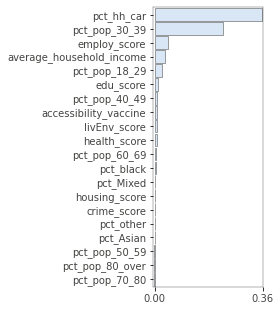

In [155]:
# feature importance
import rfpimp
imp = rfpimp.importances(rf_reg, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [156]:
# feature_name_accessibility = 'accessibility_vaccine'
# ind_accessibility = list_x_var_incl_access.index('accessibility_vaccine')
ind_pct_hh_car = list_x_var_incl_access.index('pct_hh_car')
ind_average_household_income = list_x_var_incl_access.index('average_household_income')
ind_pct_employ_score = list_x_var_incl_access.index('employ_score')
ind_pct_pop_18_29 = list_x_var_incl_access.index('pct_pop_18_29')

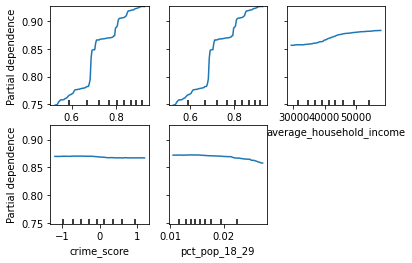

In [157]:
# partial dependence plot
# pd_result = partial_dependence(rf_reg, features=[ind_accessibility], X=train_x, kind='average')
PartialDependenceDisplay.from_estimator(rf_reg, train_x, [ind_accessibility, ind_pct_hh_car, ind_average_household_income, ind_pct_pop_30_39, ind_pct_pop_18_29], kind='average')

# Fourth RF model

This is the core RF model in this analysis.

Using RF to study the relationship between vaccine uptake rates and socioeconomic variables and accessibility scores.

In [322]:
list_x_var_incl_access = ['msoa_quintile' , 'average_household_income', 
                          'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
                          'pct_hh_car' , 
                          'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other', 'pct_White', 
                          'accessibility_vaccine']

In [323]:
df_uptake[list_x_var_incl_access].corr()

,msoa_quintile,average_household_income,pct_pop_18_29,pct_pop_30_39,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_pop_80_over,pct_hh_car,pct_Mixed,pct_Asian,pct_black,pct_other,pct_White,accessibility_vaccine
msoa_quintile,1.000000,0.706323,-0.184061,-0.461636,-0.165257,0.131452,0.247081,0.419512,0.412398,0.712479,-0.297801,-0.236847,-0.323156,-0.210713,0.320560,-0.248516
average_household_income,0.706323,1.000000,-0.153890,-0.020131,0.296400,0.015279,-0.168389,-0.056916,-0.013802,0.364811,0.187092,0.022707,0.073015,0.153374,-0.073183,-0.208481
pct_pop_18_29,-0.184061,-0.153890,1.000000,0.291469,0.223966,-0.216318,-0.322931,-0.349665,-0.274639,-0.279631,0.221095,0.330560,0.171529,0.228856,-0.324200,0.143432
pct_pop_30_39,-0.461636,-0.020131,0.291469,1.000000,0.699301,-0.530324,-0.861931,-0.894339,-0.763999,-0.739582,0.670524,0.486292,0.552530,0.526521,-0.633546,0.250347
pct_pop_40_49,-0.165257,0.296400,0.223966,0.699301,1.000000,-0.201640,-0.812262,-0.854734,-0.732754,-0.426625,0.643484,0.510487,0.494449,0.477921,-0.622279,0.148551
pct_pop_50_59,0.131452,0.015279,-0.216318,-0.530324,-0.201640,1.000000,0.426867,0.237894,0.051303,0.408542,-0.304744,-0.390442,-0.204503,-0.351209,0.395241,-0.176232
pct_pop_60_69,0.247081,-0.168389,-0.322931,-0.861931,-0.812262,0.426867,1.000000,0.832777,0.593354,0.586592,-0.674509,-0.454271,-0.524764,-0.502190,0.600528,-0.185306
pct_pop_70_80,0.419512,-0.056916,-0.349665,-0.894339,-0.854734,0.237894,0.832777,1.000000,0.808450,0.661079,-0.696126,-0.522268,-0.571225,-0.519141,0.666053,-0.248446
pct_pop_80_over,0.412398,-0.013802,-0.274639,-0.763999,-0.732754,0.051303,0.593354,0.808450,1.000000,0.515459,-0.526266,-0.370398,-0.458861,-0.381634,0.495665,-0.142699
pct_hh_car,0.712479,0.364811,-0.279631,-0.739582,-0.426625,0.408542,0.586592,0.661079,0.515459,1.000000,-0.622974,-0.374687,-0.567928,-0.545755,0.561271,-0.301246


In [324]:
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE',
       'msoa_imd_decile', 'pct_White', 'pct_Mixed', 'pct_Asian', 'pct_black',
       'pct_other', 'pct_hh_car', 'msoa_quintile', 'MSOA11CD_x',
       'income_score', 'employ_score', 'edu_score', 'health_score',
       'crime_score', 'housing_score', 'livEnv_score', 'accessibility_vaccine',
       'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [325]:
# data split
train_x, test_x, train_y, test_y = train_test_split(df_uptake[list_x_var_incl_access], df_uptake.vaccination_percentage_2nddose)

In [326]:
print(train_x.shape)
print(train_y.shape)

(5090, 16)
(5090,)


In [327]:
# build a random forest
random_state_rf = 1024
rf_reg = RandomForestRegressor(random_state=random_state_rf)
# accuracy
rf_reg.fit(train_x, train_y)
# 
print("R2 on the training data:")
print(rf_reg.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_reg.score(X=test_x, y=test_y))

print("RMSE on the training data:")
print(mean_squared_error(train_y, rf_reg.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_reg.predict(test_x), squared=False))

R2 on the training data:
0.9611518261964883
R2 on the testing data:
0.7604449391675171
RMSE on the training data:
0.019478305221162222
RMSE on the testing data:
0.04913216039305901


                          Importance
Feature                             
pct_hh_car                  0.450676
pct_pop_30_39               0.152230
pct_pop_18_29               0.060822
average_household_income    0.052418
accessibility_vaccine       0.017915
msoa_quintile               0.016143
pct_other                   0.014584
pct_White                   0.014348
pct_black                   0.013162
pct_pop_50_59               0.010802
pct_Asian                   0.010515
pct_pop_40_49               0.009391
pct_pop_70_80               0.005889
pct_pop_60_69               0.005239
pct_Mixed                   0.004491
pct_pop_80_over            -0.000172


TypeError: save() got an unexpected keyword argument 'dpi'

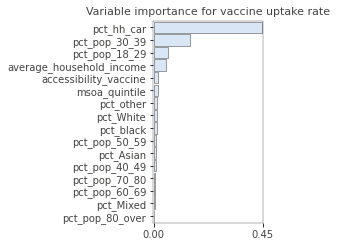

In [332]:
# feature importance
import rfpimp
imp = rfpimp.importances(rf_reg, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp, title="Variable importance for vaccine uptake rate")
viz.save('../Images/RF_variable_importance.png')
viz.view()

In [250]:
feature_name_accessibility = 'accessibility_vaccine'
ind_accessibility = list_x_var_incl_access.index('accessibility_vaccine')
ind_pct_hh_car = list_x_var_incl_access.index('pct_hh_car')
ind_average_household_income = list_x_var_incl_access.index('average_household_income')
ind_pct_pop_30_39 = list_x_var_incl_access.index('pct_pop_30_39')
ind_pct_pop_18_29 = list_x_var_incl_access.index('pct_pop_18_29')

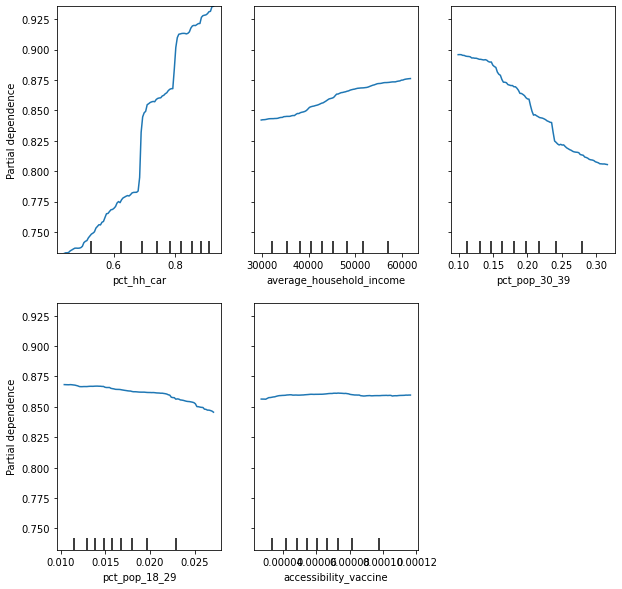

In [251]:
# partial dependence plot
f, ax = plt.subplots(1,1, figsize=(10,10))
# pd_result = partial_dependence(rf_reg, features=[ind_accessibility], X=train_x, kind='average')
PartialDependenceDisplay.from_estimator(rf_reg, train_x, [ind_pct_hh_car, ind_average_household_income, ind_pct_pop_30_39, ind_pct_pop_18_29, ind_accessibility], kind='average', ax=ax)

# Fifth RF model

What if the top four most important features are removed? (Pop_group_prop, average_household_income, pct_hh_car)

Assumption: the predictive accuracy will be much lower. The predictive accuracy decreases from 0.72 (The Fourth RF Model) to 0.53.

In [252]:
list_x_var_incl_access = ['msoa_quintile' , 
#                           'average_household_income', 
#                           'pct_pop_18_29', 'pct_pop_30_39', 
#                           'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
#                           'pct_hh_car', 
                          'pct_Mixed', 'pct_Asian' , 'pct_black' , 'pct_other', 'pct_White', 
                          'accessibility_vaccine']

In [253]:
df_uptake[list_x_var_incl_access].corr()

,msoa_quintile,pct_Mixed,pct_Asian,pct_black,pct_other,pct_White,accessibility_vaccine
msoa_quintile,1.000000,-0.297801,-0.236847,-0.323156,-0.210713,0.320560,-0.248516
pct_Mixed,-0.297801,1.000000,0.443553,0.797843,0.667749,-0.736290,0.180747
pct_Asian,-0.236847,0.443553,1.000000,0.389283,0.520282,-0.897444,0.228783
pct_black,-0.323156,0.797843,0.389283,1.000000,0.597426,-0.744644,0.111530
pct_other,-0.210713,0.667749,0.520282,0.597426,1.000000,-0.714869,0.179153
pct_White,0.320560,-0.736290,-0.897444,-0.744644,-0.714869,1.000000,-0.226475
accessibility_vaccine,-0.248516,0.180747,0.228783,0.111530,0.179153,-0.226475,1.000000


In [254]:
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE', 'pct_White',
       'pct_Mixed', 'pct_Asian', 'pct_black', 'pct_other', 'pct_hh_car',
       'msoa_quintile', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'accessibility_vaccine', 'msoa_imd_decile_1',
       'msoa_imd_decile_2', 'msoa_imd_decile_3', 'msoa_imd_decile_4',
       'msoa_imd_decile_5', 'msoa_imd_decile_6', 'msoa_imd_decile_7',
       'msoa_imd_decile_8', 'msoa_imd_decile_9', 'msoa_imd_decile_10',
       'msoa_imd_decile', 'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [255]:
# data split
train_x, test_x, train_y, test_y = train_test_split(df_uptake[list_x_var_incl_access], df_uptake.vaccination_percentage_2nddose)

In [256]:
train_x

,msoa_quintile,pct_Mixed,pct_Asian,pct_black,pct_other,pct_White,accessibility_vaccine
6030,2,0.0174,0.0250,0.0083,0.0005,0.9489,0.000079
2016,5,0.0347,0.1639,0.0331,0.0097,0.7586,0.000048
333,4,0.0089,0.0050,0.0019,0.0007,0.9834,0.000049
6142,2,0.0095,0.0087,0.0016,0.0006,0.9795,0.000067
3266,5,0.0167,0.0666,0.0051,0.0088,0.9028,0.000049
...,...,...,...,...,...,...,...
1362,3,0.0408,0.2090,0.0696,0.0618,0.6188,0.000081
3052,2,0.0167,0.1794,0.0153,0.0045,0.7841,0.000061
1850,4,0.0400,0.3722,0.0426,0.0331,0.5121,0.000044
6553,1,0.0162,0.0108,0.0033,0.0021,0.9676,0.000066


In [209]:
print(train_x.shape)
print(train_y.shape)

(5090, 7)
(5090,)


In [257]:
# build a random forest
random_state_rf = 1024
rf_reg = RandomForestRegressor(random_state=random_state_rf)
# accuracy
rf_reg.fit(train_x, train_y)
# 
print("R2 on the training data:")
print(rf_reg.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_reg.score(X=test_x, y=test_y))

print("RMSE on the training data:")
print(mean_squared_error(train_y, rf_reg.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_reg.predict(test_x), squared=False))

R2 on the training data:
0.9350711844013927
R2 on the testing data:
0.564263034978983
RMSE on the training data:
0.025410440410060228
RMSE on the testing data:
0.06444234519882032


                       Importance
Feature                          
msoa_quintile            0.379081
pct_White                0.168938
pct_other                0.152390
pct_Mixed                0.083517
pct_black                0.069966
accessibility_vaccine    0.061606
pct_Asian                0.030901


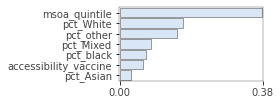

In [258]:
# feature importance
import rfpimp
imp = rfpimp.importances(rf_reg, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

# Sixth RF model

The story of vaccine uptake rate in London.

Rerun the 4th model for only London!

In [259]:
list_x_var_incl_access = ['msoa_quintile' , 'average_household_income', 
                          'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49','pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
                          'pct_hh_car', 
                          'pct_Mixed', 'pct_Asian' , 'pct_black' , 'pct_other', 'pct_White', 
                          'accessibility_vaccine']

In [260]:
df_vaccine_only_london[list_x_var_incl_access].corr()

,msoa_quintile,average_household_income,pct_pop_18_29,pct_pop_30_39,pct_pop_40_49,pct_pop_50_59,pct_pop_60_69,pct_pop_70_80,pct_pop_80_over,pct_hh_car,pct_Mixed,pct_Asian,pct_black,pct_other,pct_White,accessibility_vaccine
msoa_quintile,1.000000,0.778744,-0.287875,-0.439252,-0.199561,0.008453,0.370944,0.610033,0.537214,0.647867,-0.516093,-0.143004,-0.707969,-0.307633,0.581177,-0.137926
average_household_income,0.778744,1.000000,-0.464830,-0.070058,0.034819,-0.206556,0.023738,0.273677,0.171082,0.329414,-0.216511,-0.180677,-0.574406,-0.220800,0.502306,-0.007443
pct_pop_18_29,-0.287875,-0.464830,1.000000,-0.092504,-0.004522,0.187358,0.052342,-0.131133,-0.076201,-0.076433,-0.005176,0.246000,0.229892,0.123017,-0.337282,0.047638
pct_pop_30_39,-0.439252,-0.070058,-0.092504,1.000000,0.330069,-0.721257,-0.878037,-0.844563,-0.776382,-0.726632,0.407720,0.137110,0.322237,0.131788,-0.336382,0.230668
pct_pop_40_49,-0.199561,0.034819,-0.004522,0.330069,1.000000,-0.173026,-0.566829,-0.589860,-0.605819,-0.266052,0.291982,0.088100,0.187457,0.115796,-0.212207,0.070984
pct_pop_50_59,0.008453,-0.206556,0.187358,-0.721257,-0.173026,1.000000,0.585120,0.370719,0.297305,0.380201,0.019367,-0.252288,0.194041,-0.094607,0.108889,-0.223700
pct_pop_60_69,0.370944,0.023738,0.052342,-0.878037,-0.566829,0.585120,1.000000,0.807364,0.709846,0.649174,-0.409573,0.015044,-0.289116,-0.087015,0.190510,-0.175588
pct_pop_70_80,0.610033,0.273677,-0.131133,-0.844563,-0.589860,0.370719,0.807364,1.000000,0.873253,0.704402,-0.543667,-0.183844,-0.565774,-0.179985,0.523283,-0.193398
pct_pop_80_over,0.537214,0.171082,-0.076201,-0.776382,-0.605819,0.297305,0.709846,0.873253,1.000000,0.660642,-0.522393,-0.125280,-0.489099,-0.164694,0.431007,-0.163426
pct_hh_car,0.647867,0.329414,-0.076433,-0.726632,-0.266052,0.380201,0.649174,0.704402,0.660642,1.000000,-0.596622,0.001803,-0.514294,-0.409212,0.380350,-0.290440


In [261]:
df_vaccine_only_london.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'MSOA Code', 'pct_pop_18_29', 'pct_pop_30_39', 'pct_pop_40_49',
       'pct_pop_50_59', 'pct_pop_60_69', 'pct_pop_70_80', 'pct_pop_80_over',
       'MSOA code', 'average_household_income', 'IMD19 SCORE',
       'msoa_imd_decile', 'pct_White', 'pct_Mixed', 'pct_Asian', 'pct_black',
       'pct_other', 'pct_hh_car', 'msoa_quintile', 'MSOA11CD', 'income_score',
       'employ_score', 'edu_score', 'health_score', 'crime_score',
       'housing_score', 'livEnv_score', 'accessibility_vaccine'],
      dtype='object')

In [262]:
# data split
train_x, test_x, train_y, test_y = train_test_split(df_vaccine_only_london[list_x_var_incl_access], df_vaccine_only_london.vaccination_percentage_2nddose)

In [263]:
print(train_x.shape)
print(train_y.shape)

(735, 16)
(735,)


In [264]:
# build a random forest
random_state_rf = 1024
rf_reg = RandomForestRegressor(random_state=random_state_rf)
# accuracy
rf_reg.fit(train_x, train_y)
# 
print("R2 on the training data:")
print(rf_reg.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_reg.score(X=test_x, y=test_y))

print("RMSE on the training data:")
print(mean_squared_error(train_y, rf_reg.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_reg.predict(test_x), squared=False))

R2 on the training data:
0.9493869148076614
R2 on the testing data:
0.5790649838739972
RMSE on the training data:
0.02097761711468563
RMSE on the testing data:
0.06375370966113196


                          Importance
Feature                             
pct_hh_car                  0.409010
average_household_income    0.089302
pct_black                   0.085621
pct_pop_30_39               0.055151
pct_Asian                   0.044787
pct_other                   0.026628
pct_pop_18_29               0.021478
pct_White                   0.012603
pct_pop_50_59               0.012300
accessibility_vaccine       0.012110
pct_pop_60_69               0.011782
pct_pop_80_over             0.010530
pct_pop_70_80               0.002989
msoa_quintile              -0.001422
pct_Mixed                  -0.003770
pct_pop_40_49              -0.003802


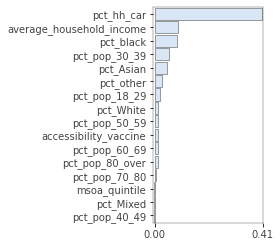

In [265]:
# feature importance
import rfpimp
imp = rfpimp.importances(rf_reg, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [165]:
# feature_name_accessibility = 'accessibility_vaccine'
# ind_accessibility = list_x_var_incl_access.index('accessibility_vaccine')
ind_pct_hh_car = list_x_var_incl_access.index('pct_hh_car')
ind_average_household_income = list_x_var_incl_access.index('average_household_income')
ind_pct_pop_30_39 = list_x_var_incl_access.index('pct_pop_30_39')
ind_pct_pop_18_29 = list_x_var_incl_access.index('pct_pop_18_29')

In [166]:
imp[0:5].index.tolist()

['pct_hh_car', 'pct_black', 'pct_pop_30_39', 'pct_White', 'pct_pop_18_29']

In [167]:
# the top five most important variables
n_top_features = 5
list_name_top_important_feature = imp[:n_top_features].index.tolist()
list_index_top_important_feature = [list_x_var_incl_access.index(fea) for fea in list_name_top_important_feature]

In [168]:
list_index_top_important_feature

[9, 12, 3, 14, 2]

In [169]:
train_x.shape

(735, 16)

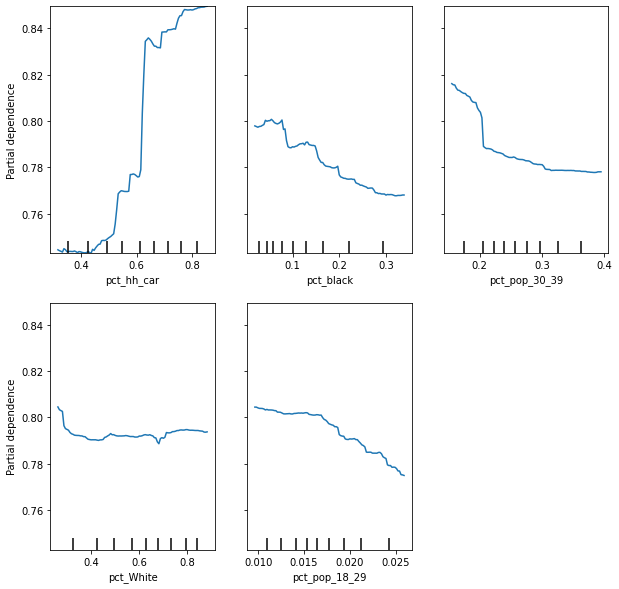

In [170]:
# partial dependence plot
f, ax = plt.subplots(1,1, figsize=(10,10))
# pd_result = partial_dependence(rf_reg, features=[ind_accessibility], X=train_x, kind='average')
PartialDependenceDisplay.from_estimator(rf_reg, train_x, list_index_top_important_feature, kind='average', ax=ax)